In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import time
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

In [2]:
def activation(x: torch.Tensor, function: str) -> torch.Tensor:
    if function == 'relu':
        return torch.where(x > 0, x, torch.zeros_like(x))
    elif function == 'sigmoid':
        return 1 / (1 + torch.exp(-x))
    elif function == 'tanh':
        return torch.tanh(x)
    elif function == 'linear':
        return x
    else:
        raise ValueError(f"Activation function {function} not supported")

In [3]:
def act_der(x: torch.Tensor, function: str) -> torch.Tensor:
    if function == 'relu':
        return (x > 0).float()
    elif function == 'sigmoid':
        sig = activation(x, 'sigmoid')
        return sig * (1 - sig)
    elif function == 'tanh':
        return 1 - activation(x, 'tanh').pow(2)
    elif function == 'linear':
        return torch.ones_like(x)
    else:
        raise ValueError(f"Activation function {function} not supported")

In [4]:
def loss(gt: torch.Tensor, pred: torch.Tensor, function: str) -> torch.Tensor:
    # Ensure tensors are on the same device
    if gt.device != pred.device:
        gt = gt.to(pred.device)
        
    if function == 'mse':
        return torch.mean((pred - gt).pow(2))
    elif function == 'bce':
        return -torch.mean(gt * torch.log(pred + 1e-7) + (1 - gt) * torch.log(1 - pred + 1e-7))

def loss_der(gt: torch.Tensor, pred: torch.Tensor, function: str) -> torch.Tensor:
    # Ensure tensors are on the same device
    if gt.device != pred.device:
        gt = gt.to(pred.device)
        
    if function == 'mse':
        return 2 * (pred - gt) / gt.size(1)
    elif function == 'bce':
        return -gt / (pred + 1e-7) + (1 - gt) / (1 - pred + 1e-7)

In [5]:
class NeuralNetwork:
    def __init__(self, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.layers = []
        self.z_list = []
        self.a_list = []
        self.device = device

    def add_layer(self, input_size: int, output_size: int, activation: str):
        # Initialize weights using He initialization for ReLU or Xavier for sigmoid/tanh
        if activation == 'relu':
            w = torch.randn(output_size, input_size, device=self.device) * torch.sqrt(torch.tensor(2.0 / input_size, device=self.device))
        else:
            w = torch.randn(output_size, input_size, device=self.device) * torch.sqrt(torch.tensor(1.0 / input_size, device=self.device))
            
        b = torch.zeros(output_size, 1, device=self.device)
        self.layers.append([w, b, activation])
        self.z_list.append(None)
        self.a_list.append(None)

    def forwardprop(self, x: torch.Tensor) -> torch.Tensor:
        current_input = x.to(self.device)  # Ensure input is on the correct device
        for i in range(len(self.layers)):
            w, b, activation_func = self.layers[i]
            z = torch.mm(w, current_input) + b
            self.z_list[i] = z
            self.a_list[i] = activation(z, activation_func)
            current_input = self.a_list[i]
        return self.a_list[-1]

    def backprop(self, x: torch.Tensor, y: torch.Tensor, loss_function: str, learning_rate: float = 0.01):
        m = x.size(1)  # Number of samples is now the second dimension
        self.forwardprop(x)
        
        dz = loss_der(y, self.a_list[-1], loss_function)
        for i in range(len(self.layers)-1, -1, -1):
            w, b, activation_func = self.layers[i]
            a_prev = self.a_list[i-1] if i > 0 else x
            
            dz = dz * act_der(self.z_list[i], activation_func)
            dw = (1/m) * torch.mm(dz, a_prev.T)
            db = (1/m) * torch.sum(dz, dim=1, keepdim=True)
            
            self.layers[i][0] = w - learning_rate * dw
            self.layers[i][1] = b - learning_rate * db
            
            if i > 0:
                dz = torch.mm(w.T, dz)

    def train(self, X: torch.Tensor, y: torch.Tensor, epochs: int = 100, 
             batch_size: int = 32, learning_rate: float = 0.01, 
             loss_function: str = 'mse', optimizer: str = 'Mini_Batch', verbose: bool = True):
        n_samples = X.size(1)  # Now samples are columns
        
        X = X.to(self.device)  # Move X to the correct device
        y = y.to(self.device)  # Move y to the correct device
        
        epoch_losses = []

        for epoch in range(epochs):
            total_loss = 0.0
            # Generate random permutation indices on the same device as X
            perm = torch.randperm(n_samples, device=self.device)
            X_shuffled = X[:, perm]
            y_shuffled = y[:, perm]  # Correctly index y with perm
            
            if optimizer == 'Batch':
                # Process all samples at once
                pred = self.forwardprop(X_shuffled)
                batch_loss = loss(y_shuffled, pred, loss_function)
                total_loss += batch_loss.item()
                self.backprop(X_shuffled, y_shuffled, loss_function, learning_rate)
            
            elif optimizer == 'SGD':
                # Stochastic Gradient Descent - process one sample at a time
                for i in range(n_samples):
                    X_sample = X_shuffled[:, i:i+1]  # Get a single sample
                    y_sample = y_shuffled[:, i:i+1]  # Get corresponding label
                    
                    pred = self.forwardprop(X_sample)
                    sample_loss = loss(y_sample, pred, loss_function)
                    total_loss += sample_loss.item()
                    
                    self.backprop(X_sample, y_sample, loss_function, learning_rate)
                
                total_loss = total_loss / n_samples  # Average the loss over samples
            
            else:  # Mini_Batch (default)
                n_batches = (n_samples + batch_size - 1) // batch_size
                
                for batch in range(n_batches):
                    start_idx = batch * batch_size
                    end_idx = min((batch + 1) * batch_size, n_samples)
                    
                    X_batch = X_shuffled[:, start_idx:end_idx]
                    y_batch = y_shuffled[:, start_idx:end_idx]
                    
                    pred = self.forwardprop(X_batch)
                    batch_loss = loss(y_batch, pred, loss_function)
                    total_loss += batch_loss.item()
                    
                    self.backprop(X_batch, y_batch, loss_function, learning_rate)
                
                total_loss = total_loss / n_batches  # Average loss over batches
            
            epoch_losses.append(total_loss)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss:.4f}")
                
        return epoch_losses  # Return the loss history

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network to make predictions"""
        return self.forwardprop(X)



In [6]:
import torch
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import itertools

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
ENGLISH_STOPWORDS = set([
    'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and',
    'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being',
    'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't",
    'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during',
    'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have',
    "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's",
    'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll",
    "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself',
    "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not',
    'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 
    'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll",
    "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's",
    'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's",
    'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those',
    'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we',
    "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when',
    "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why',
    "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're",
    "you've", 'your', 'yours', 'yourself', 'yourselves'
])

In [9]:
class ArticleDataProcessor:
    """Class to handle all data preprocessing operations"""
    
    def __init__(self, max_features=5000):
        self.max_features = max_features
        self.vocabulary = None
        self.idf_values = None
        self.label_dict = None
    
    def sanitize_text(self, text):
        """Clean text by removing special characters and converting to lowercase"""
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()
        # Remove non-alphanumeric characters
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return text
    
    def get_tokens(self, text):
        """Split text into tokens and remove stopwords"""
        words = text.split()
        return [w for w in words if w not in ENGLISH_STOPWORDS and len(w) > 1]
    
    def extract_top_terms(self, documents):
        """Build vocabulary with most frequent terms"""
        word_counts = Counter()
        for doc in documents:
            tokens = self.get_tokens(doc)
            word_counts.update(tokens)
        
        # Get top terms
        top_terms = word_counts.most_common(self.max_features)
        self.vocabulary = {term: idx for idx, (term, _) in enumerate(top_terms)}
        return self.vocabulary
    
    def calculate_idf(self, documents):
        """Calculate inverse document frequency"""
        doc_count = len(documents)
        term_doc_count = np.zeros(len(self.vocabulary))
        
        for doc in documents:
            tokens = set(self.get_tokens(doc))  # Use set to count each term once per document
            for token in tokens:
                if token in self.vocabulary:
                    term_doc_count[self.vocabulary[token]] += 1
        
        # Calculate IDF with smoothing
        self.idf_values = np.log((doc_count + 1) / (term_doc_count + 1)) + 1
        return self.idf_values
    
    def vectorize_document(self, document):
        """Convert a single document to TF-IDF vector"""
        if self.vocabulary is None or self.idf_values is None:
            raise ValueError("Vocabulary and IDF values must be computed first")
        
        # Initialize vector
        vector = np.zeros(len(self.vocabulary))
        
        # Get tokens and their counts
        tokens = self.get_tokens(document)
        if not tokens:
            return vector
            
        token_counts = Counter(tokens)
        total_tokens = len(tokens)
        
        # Calculate TF-IDF
        for token, count in token_counts.items():
            if token in self.vocabulary:
                idx = self.vocabulary[token]
                tf = count / total_tokens
                vector[idx] = tf * self.idf_values[idx]
                
        return vector
    
    def vectorize_documents(self, documents):
        """Convert a list of documents to TF-IDF matrix"""
        if self.vocabulary is None or self.idf_values is None:
            raise ValueError("Vocabulary and IDF values must be computed first")
            
        # Initialize matrix
        X = np.zeros((len(documents), len(self.vocabulary)))
        
        # Process each document
        for i, doc in enumerate(documents):
            X[i] = self.vectorize_document(doc)
            
        return X
    
    def process_labels(self, labels):
        """Convert multi-label categories to binary matrix"""
        if self.label_dict is None:
            # First time processing - create label dictionary
            unique_labels = set()
            for label_str in labels:
                # Split comma-separated labels
                label_list = [l.strip() for l in str(label_str).split(',') if l.strip()]
                unique_labels.update(label_list)
            
            # Create label mapping
            self.label_dict = {label: idx for idx, label in enumerate(sorted(unique_labels))}
        
        # Initialize binary matrix
        Y = np.zeros((len(labels), len(self.label_dict)))
        
        # Fill binary matrix
        for i, label_str in enumerate(labels):
            label_list = [l.strip() for l in str(label_str).split(',') if l.strip()]
            for label in label_list:
                if label in self.label_dict:
                    Y[i, self.label_dict[label]] = 1
                    
        return Y
    
    def prepare_data(self, train_file, test_file=None, val_split=0.2):
        """Prepare data for training and evaluation"""
        # Read training data
        print("Reading training data...")
        train_df = pd.read_csv(train_file)
        train_df.dropna(subset=['document', 'category'], inplace=True)
        
        # Clean text
        print("Cleaning text...")
        train_df['document'] = train_df['document'].apply(self.sanitize_text)
        
        # Extract features
        print("Extracting features...")
        documents = train_df['document'].tolist()
        self.extract_top_terms(documents)
        self.calculate_idf(documents)
        
        # Convert to TF-IDF
        print("Converting to TF-IDF...")
        X = self.vectorize_documents(documents)
        
        # Process labels
        print("Processing labels...")
        Y = self.process_labels(train_df['category'].tolist())
        
        # Split into train and validation
        print("Splitting into train and validation...")
        X_train, X_val, Y_train, Y_val = train_test_split(
            X, Y, test_size=val_split, random_state=42
        )
        
        # If test file provided, process it
        if test_file:
            print("Processing test data...")
            test_df = pd.read_csv(test_file)
            test_df.dropna(subset=['document', 'category'], inplace=True)
            test_df['document'] = test_df['document'].apply(self.sanitize_text)
            
            X_test = self.vectorize_documents(test_df['document'].tolist())
            Y_test = self.process_labels(test_df['category'].tolist())
            
            return X_train, Y_train, X_val, Y_val, X_test, Y_test
        
        return X_train, Y_train, X_val, Y_val, None, None


In [10]:

class NewsClassifier:
    """Class to handle model creation, training, and evaluation"""
    
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def create_model(self, hidden_sizes, activation):
        """Create neural network with specified architecture"""
        model = NeuralNetwork(device=self.device)
        
        # Add layers
        current_size = self.input_size
        
        for hidden_size in hidden_sizes:
            model.add_layer(current_size, hidden_size, activation)
            current_size = hidden_size
            
        # Output layer with sigmoid activation
        model.add_layer(current_size, self.output_size, 'sigmoid')
        
        return model
    
    def train_model(self, model, X_train, Y_train, X_val, Y_val, 
                   learning_rate=0.01, epochs=100, batch_size=32, 
                   optimizer='Mini_Batch', verbose=True):
        """Train model and return metrics"""
        # Prepare data for our neural network (transpose to match nn interface)
        X_train_t = torch.tensor(X_train.T, dtype=torch.float32, device=self.device)
        Y_train_t = torch.tensor(Y_train.T, dtype=torch.float32, device=self.device)
        X_val_t = torch.tensor(X_val.T, dtype=torch.float32, device=self.device)
        Y_val_t = torch.tensor(Y_val.T, dtype=torch.float32, device=self.device)
        
        # Initialize lists to track metrics
        train_losses = []
        val_losses = []
        val_exact_matches = []
        
        # Train the model
        start_time = time.time()
        
        # Get initial validation metrics
        val_metrics = self.evaluate_model(model, X_val, Y_val)
        val_losses.append(val_metrics['bce_loss'])
        val_exact_matches.append(val_metrics['exact_match'])
        
        # Get model's train method result (epoch losses)
        epoch_losses = model.train(
            X_train_t, Y_train_t,
            epochs=epochs,
            learning_rate=learning_rate,
            loss_function='bce',
            optimizer=optimizer,
            batch_size=batch_size,
            verbose=verbose
        )
        
        # Record training losses
        train_losses = epoch_losses
        
        # Get final validation metrics for each epoch
        for epoch in range(1, epochs):
            if epoch % 10 == 0 or epoch == epochs-1:
                val_metrics = self.evaluate_model(model, X_val, Y_val)
                val_losses.append(val_metrics['bce_loss'])
                val_exact_matches.append(val_metrics['exact_match'])
        
        train_time = time.time() - start_time
        
        # Get final validation metrics
        final_val_metrics = self.evaluate_model(model, X_val, Y_val)
        
        # Create a dictionary to store all metrics
        metrics = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_exact_matches': val_exact_matches,
            'final_val_metrics': final_val_metrics,
            'train_time': train_time
        }
        
        return model, metrics
    
    def evaluate_model(self, model, X, Y, threshold=0.5):
        """Evaluate model performance"""
        # Prepare data
        X_t = torch.tensor(X.T, dtype=torch.float32, device=self.device)
        Y_t = torch.tensor(Y.T, dtype=torch.float32, device=self.device)
        
        # Get predictions
        with torch.no_grad():
            Y_pred = model.predict(X_t)
            Y_pred_binary = (Y_pred > threshold).float()
        
        # Calculate metrics
        hamming_loss = torch.mean(torch.abs(Y_t - Y_pred_binary)).item()
        exact_match = torch.mean(torch.all(Y_pred_binary == Y_t, dim=0).float()).item()
        
        # Calculate BCE loss
        bce_loss = -torch.mean(Y_t * torch.log(Y_pred + 1e-7) + 
                              (1 - Y_t) * torch.log(1 - Y_pred + 1e-7)).item()
        
        return {
            'hamming_loss': hamming_loss,
            'exact_match': exact_match,
            'bce_loss': bce_loss
        }
    
    def run_hyperparameter_search(self, X_train, Y_train, X_val, Y_val, X_test, Y_test,
                                 param_grid, save_plots=True):
        """Run hyperparameter search"""
        results = []
        best_hamming_loss = float('inf')
        best_config = None
        
        # Store activation-optimizer performance
        act_opt_performance = {}
        
        # Print overall info
        print(f"Running hyperparameter search with {len(param_grid['learning_rate']) * len(param_grid['epochs']) * len(param_grid['hidden_sizes']) * len(param_grid['activation']) * len(param_grid['optimizer'])} configurations")
        
        # Run all combinations
        for lr, epochs, arch, act, opt in itertools.product(
            param_grid['learning_rate'],
            param_grid['epochs'],
            param_grid['hidden_sizes'],
            param_grid['activation'],
            param_grid['optimizer']
        ):
            config_name = f"lr={lr}_epochs={epochs}_arch={arch}_act={act}_opt={opt}"
            print(f"\nTraining with {config_name}")
            
            # Create and train model
            model = self.create_model(arch, act)
            model, metrics = self.train_model(
                model, X_train, Y_train, X_val, Y_val,
                learning_rate=lr, epochs=epochs, optimizer=opt
            )
            
            # Evaluate on test set
            test_metrics = self.evaluate_model(model, X_test, Y_test) if X_test is not None else None
            
            # Print validation and test metrics
            print(f"Validation metrics: Hamming Loss={metrics['final_val_metrics']['hamming_loss']:.4f}, "
                  f"Exact Match={metrics['final_val_metrics']['exact_match']:.4f}, "
                  f"BCE Loss={metrics['final_val_metrics']['bce_loss']:.4f}")
            
            if test_metrics:
                print(f"Test metrics: Hamming Loss={test_metrics['hamming_loss']:.4f}, "
                      f"Exact Match={test_metrics['exact_match']:.4f}, "
                      f"BCE Loss={test_metrics['bce_loss']:.4f}")
            
            print(f"Training time: {metrics['train_time']:.2f} seconds")
            
            # Store configuration results
            config_result = {
                'learning_rate': lr,
                'epochs': epochs,
                'architecture': arch,
                'activation': act,
                'optimizer': opt,
                'val_metrics': metrics['final_val_metrics'],
                'test_metrics': test_metrics,
                'train_losses': metrics['train_losses'],
                'val_losses': metrics['val_losses'],
                'val_exact_matches': metrics['val_exact_matches'],
                'train_time': metrics['train_time']
            }
            results.append(config_result)
            
            # Track best configuration
            if metrics['final_val_metrics']['hamming_loss'] < best_hamming_loss:
                best_hamming_loss = metrics['final_val_metrics']['hamming_loss']
                best_config = config_result
            
            # Store in activation-optimizer mapping
            act_opt_key = (act, opt)
            if act_opt_key not in act_opt_performance or metrics['final_val_metrics']['hamming_loss'] < act_opt_performance[act_opt_key]['hamming_loss']:
                act_opt_performance[act_opt_key] = {
                    'hamming_loss': metrics['final_val_metrics']['hamming_loss'],
                    'exact_match': metrics['final_val_metrics']['exact_match'],
                    'config': config_result
                }
            
            # Plot learning curve if requested
            if save_plots:
                plt.figure(figsize=(10, 6))
                
                # Plot available epochs
                epochs_trained = len(metrics['train_losses'])
                x_train = list(range(1, epochs_trained + 1))
                
                # Plot training loss
                train_line, = plt.plot(x_train, metrics['train_losses'], label='Training Loss', 
                                      color='blue', linewidth=2)
                
                # Plot validation metrics (may have fewer points)
                if metrics['val_losses']:
                    # Create x points for validation (every 10 epochs)
                    x_val = list(range(0, epochs_trained, max(1, epochs_trained // len(metrics['val_losses']))))
                    if len(x_val) < len(metrics['val_losses']):
                        x_val.append(epochs_trained)
                    x_val = x_val[:len(metrics['val_losses'])]
                    
                    val_line, = plt.plot(x_val, metrics['val_losses'], label='Validation Loss', 
                                        marker='o', color='orange', linewidth=2)
                    
                    # Plot validation exact match on secondary axis if available
                    if metrics['val_exact_matches']:
                        ax2 = plt.gca().twinx()
                        exact_line, = ax2.plot(x_val, metrics['val_exact_matches'], label='Exact Match', 
                                              color='green', marker='s', linestyle='--', linewidth=2)
                        ax2.set_ylabel('Exact Match (Accuracy)', fontsize=12)
                        ax2.set_ylim([0, 1])
                        
                        # Create a combined legend
                        lines = [train_line, val_line, exact_line]
                        labels = ['Training Loss (BCE)', 'Validation Loss (BCE)', 'Exact Match (Accuracy)']
                        plt.legend(lines, labels, loc='upper right', fontsize=10)
                    else:
                        plt.legend(loc='upper right', fontsize=10)
                else:
                    plt.legend(loc='upper right', fontsize=10)
                
                plt.title(f'Training & Validation Metrics: {config_name}', fontsize=14)
                plt.xlabel('Epoch', fontsize=12)
                plt.ylabel('BCE Loss', fontsize=12)
                plt.grid(True)
                plt.tight_layout()
                plt.show()
                # plt.savefig(f'metrics_{act}_{opt}_lr{lr}.png', dpi=300)
                plt.close()
        
        # Sort results by test performance if available, otherwise by validation
        if X_test is not None:
            results.sort(key=lambda x: x['test_metrics']['hamming_loss'] if x['test_metrics'] else float('inf'))
            metric_key = 'test_metrics'
        else:
            results.sort(key=lambda x: x['val_metrics']['hamming_loss'])
            metric_key = 'val_metrics'
        
        # Print results in a tabular format
        print("\n======= MODEL CONFIGURATIONS RANKED BY HAMMING LOSS (BEST TO WORST) =======")
        print(f"{'Rank':<5}{'Learning Rate':<15}{'Architecture':<20}{'Activation':<10}{'Optimizer':<15}{'Hamming Loss':<12}{'Exact Match':<12}{'BCE Loss':<12}")
        print("="*89)
        
        for i, res in enumerate(results):
            metrics = res[metric_key]
            if metrics:
                print(f"{i+1:<5}{res['learning_rate']:<15}{str(res['architecture']):<20}{res['activation']:<10}{res['optimizer']:<15}"
                      f"{metrics['hamming_loss']:.5f}{'':<6}{metrics['exact_match']:.5f}{'':<6}{metrics['bce_loss']:.5f}")
        
        # Print best configuration
        print("\n===== BEST CONFIGURATION =====")
        print(f"Learning Rate: {best_config['learning_rate']}")
        print(f"Architecture: {best_config['architecture']}")
        print(f"Activation Function: {best_config['activation']}")
        print(f"Optimizer: {best_config['optimizer']}")
        print(f"Hamming Loss: {best_config[metric_key]['hamming_loss']:.5f}")
        print(f"Exact Match: {best_config[metric_key]['exact_match']:.5f}")
        print(f"BCE Loss: {best_config[metric_key]['bce_loss']:.5f}")
        
        return results, best_config, act_opt_performance
    
    def train_final_model(self, X_train, Y_train, X_val, Y_val, X_test, Y_test, config):
        """Train final model with best configuration"""
        print(f"\nTraining final model with configuration: "
              f"LR={config['learning_rate']}, Epochs={config['epochs']}, "
              f"Architecture={config['architecture']}, Activation={config['activation']}, "
              f"Optimizer={config['optimizer']}")
        
        # Create model
        model = self.create_model(config['architecture'], config['activation'])
        
        # Train model
        model, metrics = self.train_model(
            model, X_train, Y_train, X_val, Y_val,
            learning_rate=config['learning_rate'],
            epochs=config['epochs'],
            optimizer=config['optimizer'],
            verbose=True
        )
        
        # Plot final learning curve
        plt.figure(figsize=(10, 6))
        
        # Plot training loss
        epochs_trained = len(metrics['train_losses'])
        x_train = list(range(1, epochs_trained + 1))
        train_line, = plt.plot(x_train, metrics['train_losses'], label='Training Loss', 
                              color='blue', linewidth=2)
        
        # Plot validation metrics
        if metrics['val_losses']:
            # Create x points for validation (every 10 epochs)
            x_val = list(range(0, epochs_trained, max(1, epochs_trained // len(metrics['val_losses']))))
            if len(x_val) < len(metrics['val_losses']):
                x_val.append(epochs_trained)
            x_val = x_val[:len(metrics['val_losses'])]
            
            val_line, = plt.plot(x_val, metrics['val_losses'], label='Validation Loss', 
                                marker='o', color='orange', linewidth=2)
            
            # Plot validation exact match on secondary axis
            if metrics['val_exact_matches']:
                ax2 = plt.gca().twinx()
                exact_line, = ax2.plot(x_val, metrics['val_exact_matches'], label='Exact Match', 
                                      color='green', marker='s', linestyle='--', linewidth=2)
                ax2.set_ylabel('Exact Match (Accuracy)', fontsize=12)
                ax2.set_ylim([0, 1])
                
                # Create a combined legend
                lines = [train_line, val_line, exact_line]
                labels = ['Training Loss (BCE)', 'Validation Loss (BCE)', 'Exact Match (Accuracy)']
                plt.legend(lines, labels, loc='upper right', fontsize=10)
            else:
                plt.legend(loc='upper right', fontsize=10)
        else:
            plt.legend(loc='upper right', fontsize=10)
        
        plt.title('Final Model Training & Validation Metrics', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('BCE Loss', fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # plt.savefig('final_model_metrics.png', dpi=300)
        plt.close()
        
        # Evaluate on test set
        test_metrics = self.evaluate_model(model, X_test, Y_test)
        
        print(f"Final Test Metrics:")
        print(f"  Hamming Loss: {test_metrics['hamming_loss']:.4f}")
        print(f"  Exact Match: {test_metrics['exact_match']:.4f}")
        print(f"  BCE Loss: {test_metrics['bce_loss']:.4f}")
        
        return model, test_metrics



Reading training data...
Cleaning text...
Extracting features...
Converting to TF-IDF...
Processing labels...
Splitting into train and validation...
Processing test data...
Data shapes:
X_train: (6215, 5000), Y_train: (6215, 90)
X_val: (1554, 5000), Y_val: (1554, 90)
X_test: (3019, 5000), Y_test: (3019, 90)
Running hyperparameter search with 72 configurations

Training with lr=0.01_epochs=50_arch=[256, 128]_act=relu_opt=Batch
Epoch 10/50, Loss: 0.6534
Epoch 20/50, Loss: 0.5640
Epoch 30/50, Loss: 0.3271
Epoch 40/50, Loss: 0.1131
Epoch 50/50, Loss: 0.0681
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0665
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0665
Training time: 1.67 seconds


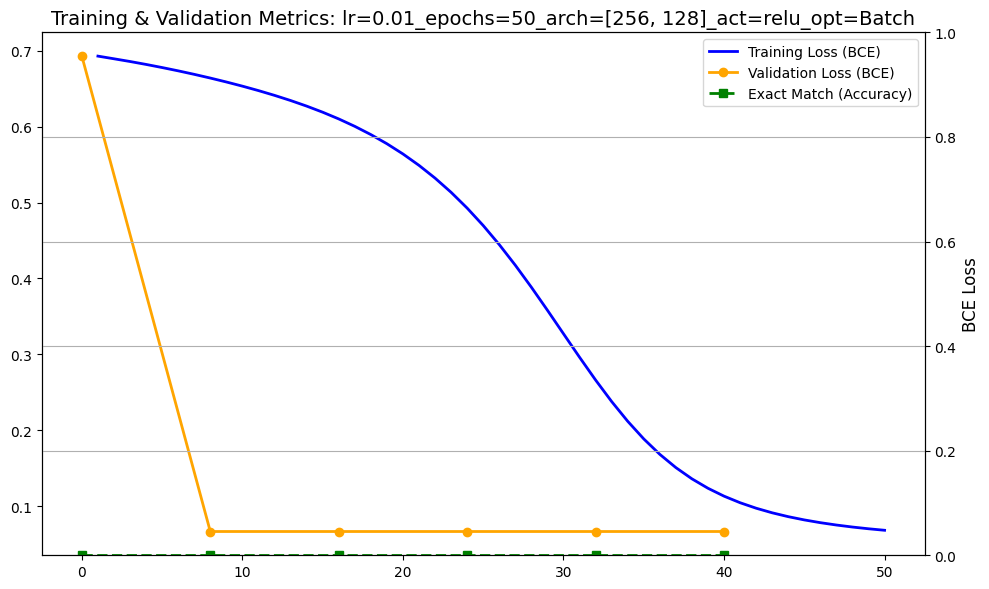


Training with lr=0.01_epochs=50_arch=[256, 128]_act=relu_opt=Mini_Batch
Epoch 10/50, Loss: 0.0441
Epoch 20/50, Loss: 0.0386
Epoch 30/50, Loss: 0.0336
Epoch 40/50, Loss: 0.0300
Epoch 50/50, Loss: 0.0274
Validation metrics: Hamming Loss=0.0071, Exact Match=0.5515, BCE Loss=0.0279
Test metrics: Hamming Loss=0.0072, Exact Match=0.5694, BCE Loss=0.0291
Training time: 13.53 seconds


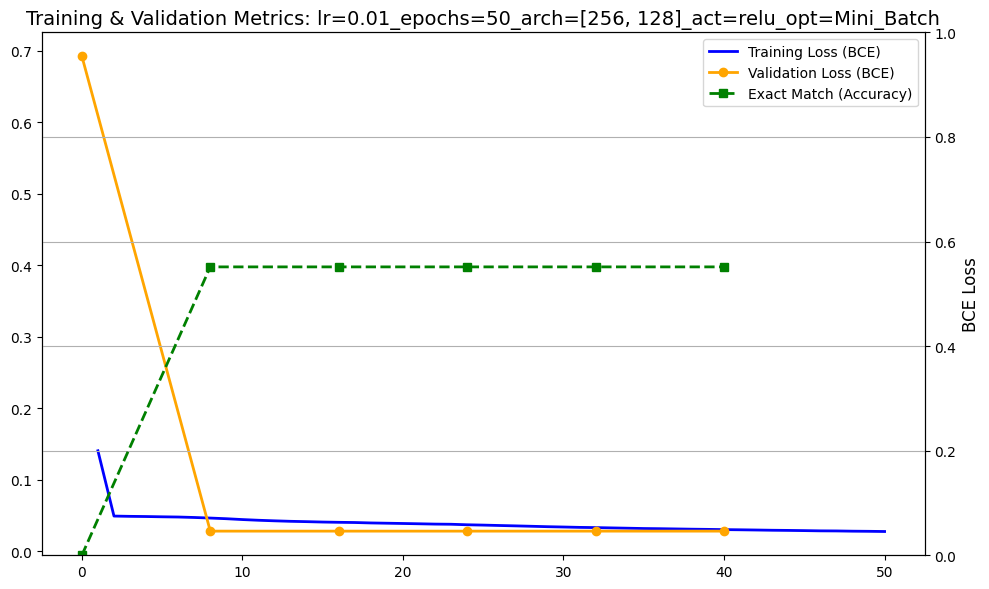


Training with lr=0.01_epochs=50_arch=[256, 128]_act=relu_opt=SGD
Epoch 10/50, Loss: 0.0095
Epoch 20/50, Loss: 0.0040
Epoch 30/50, Loss: 0.0022
Epoch 40/50, Loss: 0.0014
Epoch 50/50, Loss: 0.0011
Validation metrics: Hamming Loss=0.0031, Exact Match=0.8275, BCE Loss=0.0154
Test metrics: Hamming Loss=0.0039, Exact Match=0.7913, BCE Loss=0.0194
Training time: 394.17 seconds


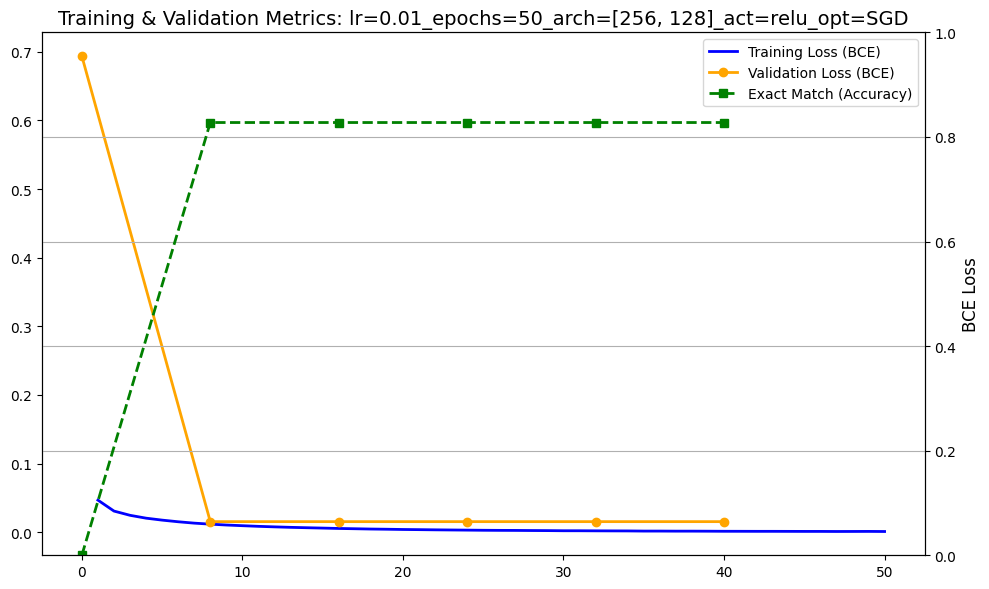


Training with lr=0.01_epochs=50_arch=[256, 128]_act=tanh_opt=Batch
Epoch 10/50, Loss: 0.6375
Epoch 20/50, Loss: 0.5245
Epoch 30/50, Loss: 0.3160
Epoch 40/50, Loss: 0.1639
Epoch 50/50, Loss: 0.1062
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.1029
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.1030
Training time: 1.21 seconds


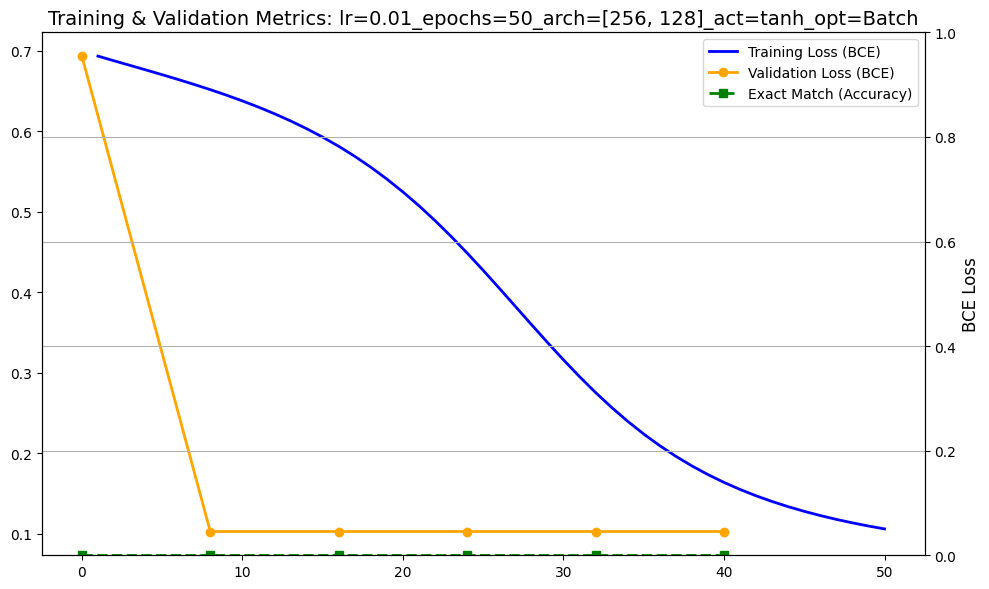


Training with lr=0.01_epochs=50_arch=[256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/50, Loss: 0.0487
Epoch 20/50, Loss: 0.0423
Epoch 30/50, Loss: 0.0391
Epoch 40/50, Loss: 0.0360
Epoch 50/50, Loss: 0.0319
Validation metrics: Hamming Loss=0.0078, Exact Match=0.5270, BCE Loss=0.0321
Test metrics: Hamming Loss=0.0077, Exact Match=0.5442, BCE Loss=0.0331
Training time: 12.00 seconds


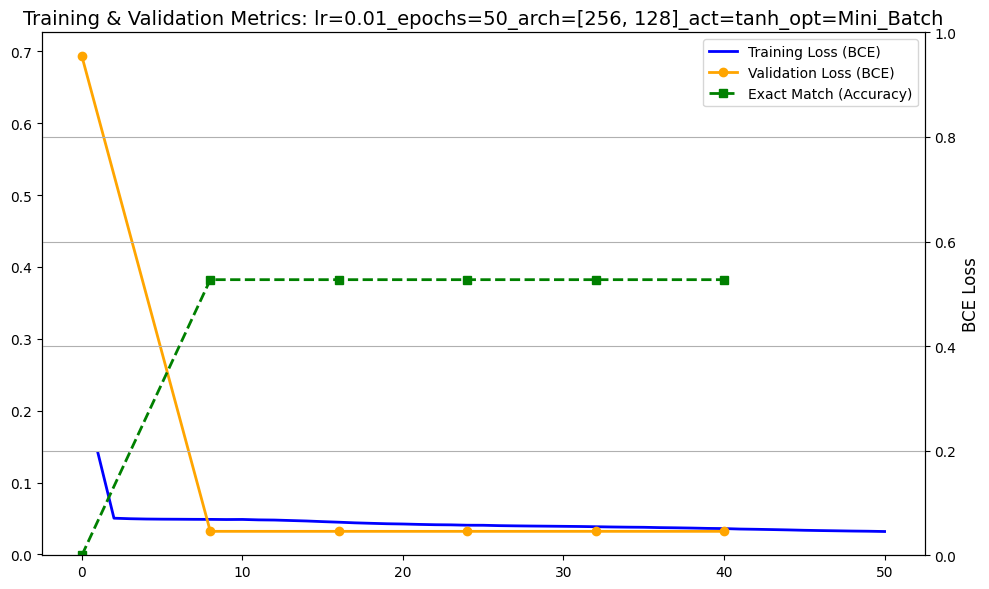


Training with lr=0.01_epochs=50_arch=[256, 128]_act=tanh_opt=SGD
Epoch 10/50, Loss: 0.0112
Epoch 20/50, Loss: 0.0050
Epoch 30/50, Loss: 0.0028
Epoch 40/50, Loss: 0.0019
Epoch 50/50, Loss: 0.0014
Validation metrics: Hamming Loss=0.0032, Exact Match=0.8205, BCE Loss=0.0150
Test metrics: Hamming Loss=0.0041, Exact Match=0.7900, BCE Loss=0.0195
Training time: 352.70 seconds


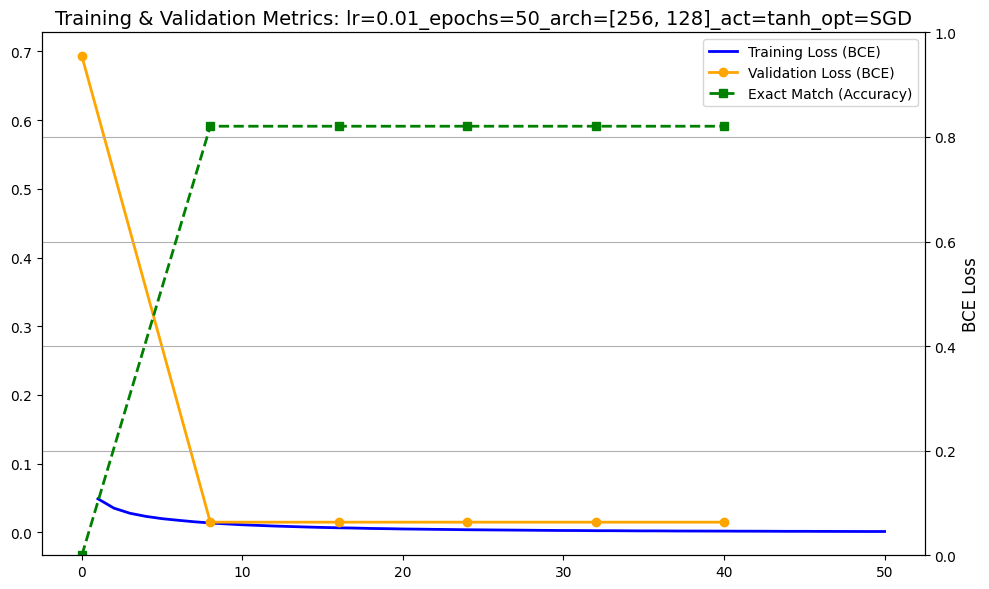


Training with lr=0.01_epochs=50_arch=[256, 128]_act=sigmoid_opt=Batch
Epoch 10/50, Loss: 0.2632
Epoch 20/50, Loss: 0.1305
Epoch 30/50, Loss: 0.0919
Epoch 40/50, Loss: 0.0760
Epoch 50/50, Loss: 0.0679
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0674
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0675
Training time: 1.29 seconds


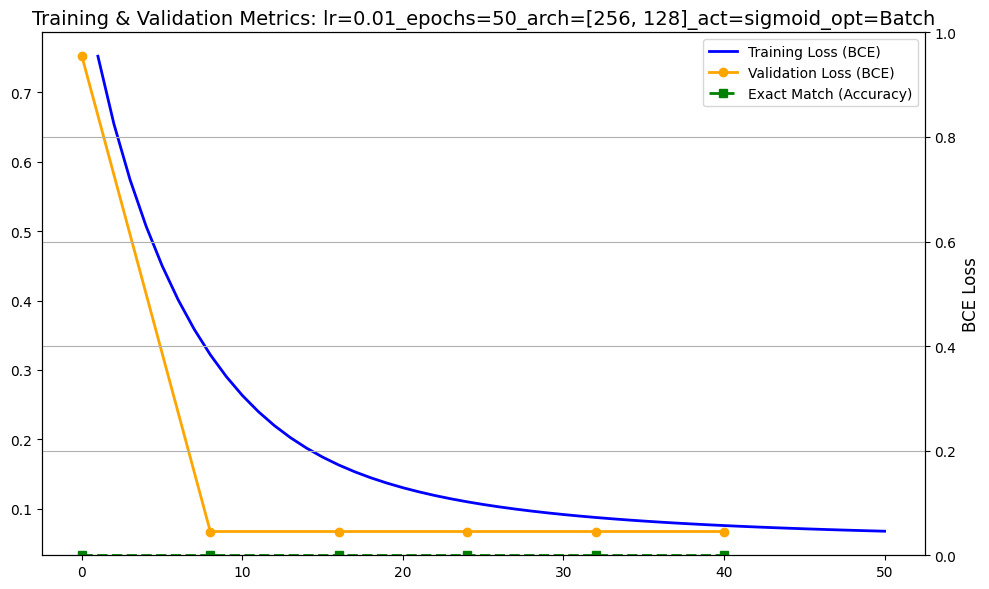


Training with lr=0.01_epochs=50_arch=[256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/50, Loss: 0.0493
Epoch 20/50, Loss: 0.0490
Epoch 30/50, Loss: 0.0490
Epoch 40/50, Loss: 0.0490
Epoch 50/50, Loss: 0.0492
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0491
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0501
Training time: 14.46 seconds


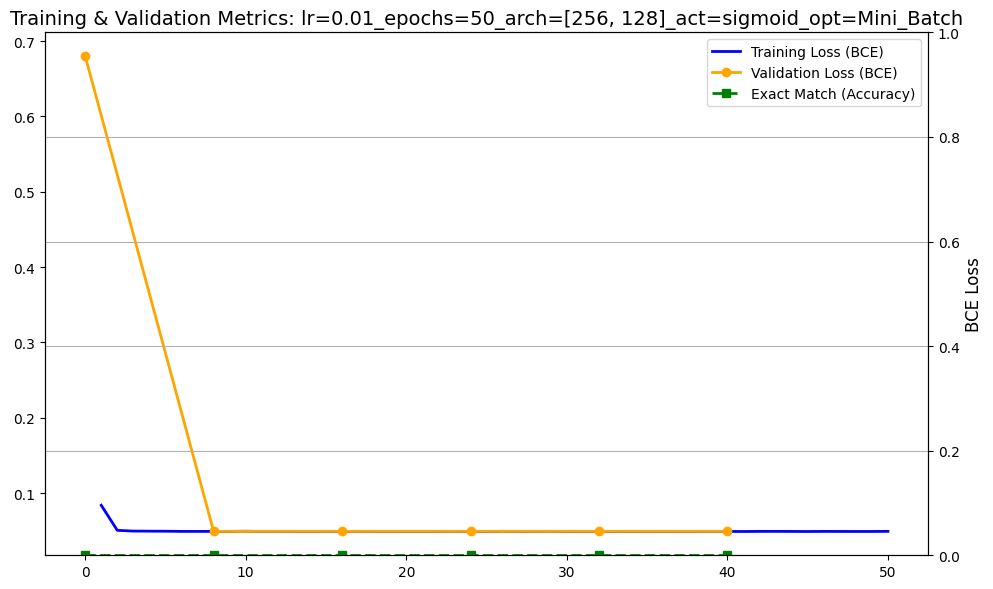


Training with lr=0.01_epochs=50_arch=[256, 128]_act=sigmoid_opt=SGD
Epoch 10/50, Loss: 0.0418
Epoch 20/50, Loss: 0.0349
Epoch 30/50, Loss: 0.0284
Epoch 40/50, Loss: 0.0238
Epoch 50/50, Loss: 0.0207
Validation metrics: Hamming Loss=0.0062, Exact Match=0.6049, BCE Loss=0.0222
Test metrics: Hamming Loss=0.0065, Exact Match=0.6231, BCE Loss=0.0243
Training time: 427.31 seconds


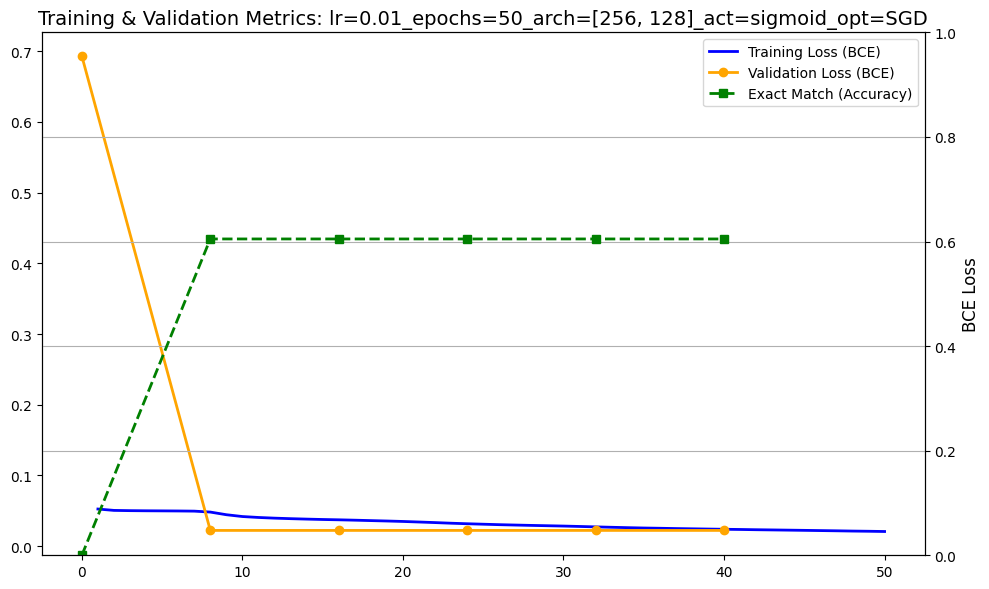


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=relu_opt=Batch
Epoch 10/50, Loss: 0.6470
Epoch 20/50, Loss: 0.4744
Epoch 30/50, Loss: 0.0872
Epoch 40/50, Loss: 0.0552
Epoch 50/50, Loss: 0.0516
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0515
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0516
Training time: 2.00 seconds


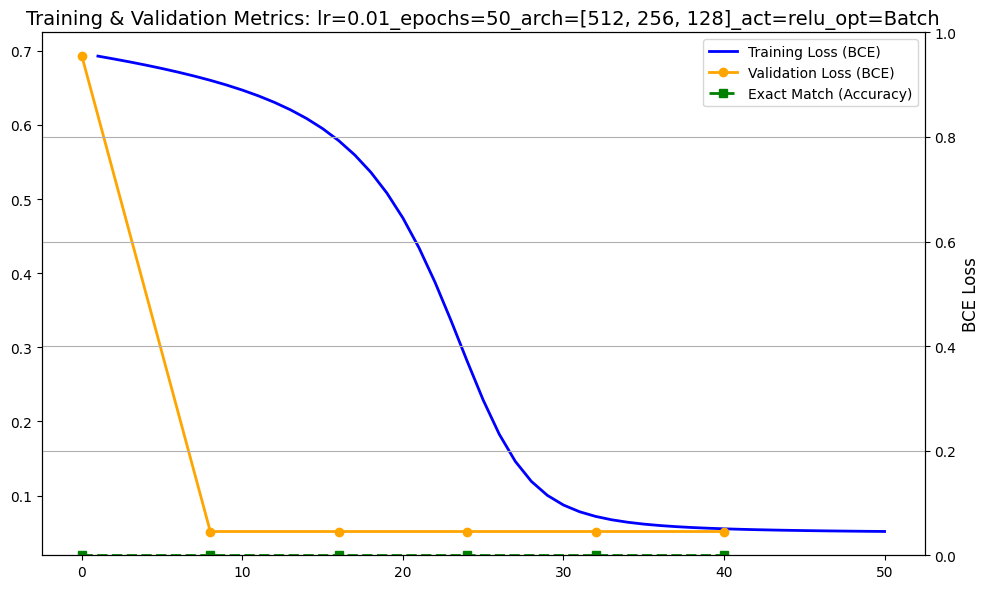


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=relu_opt=Mini_Batch
Epoch 10/50, Loss: 0.0398
Epoch 20/50, Loss: 0.0324
Epoch 30/50, Loss: 0.0267
Epoch 40/50, Loss: 0.0234
Epoch 50/50, Loss: 0.0205
Validation metrics: Hamming Loss=0.0059, Exact Match=0.6190, BCE Loss=0.0220
Test metrics: Hamming Loss=0.0063, Exact Match=0.6300, BCE Loss=0.0239
Training time: 16.45 seconds


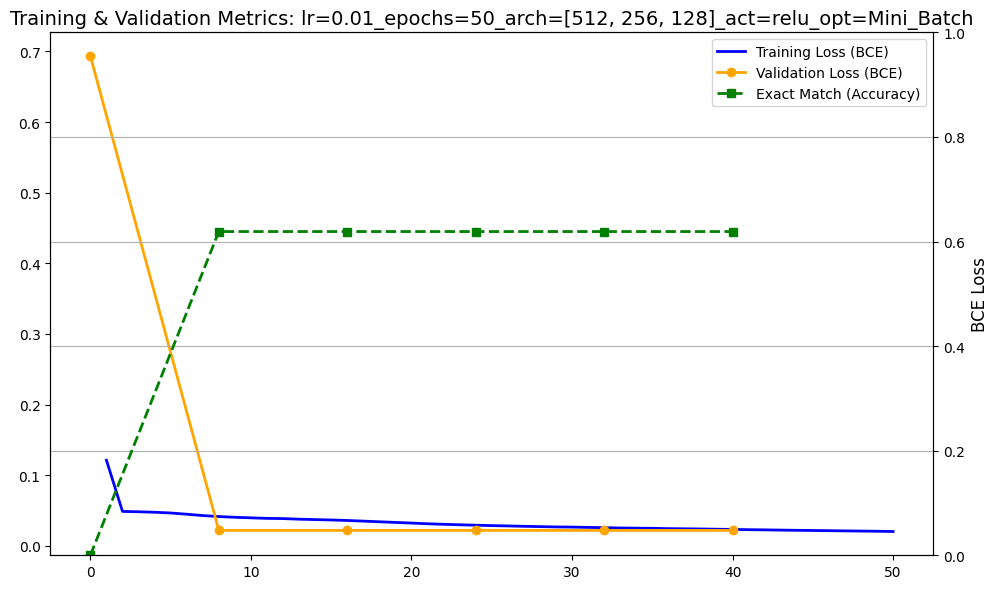


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=relu_opt=SGD
Epoch 10/50, Loss: 0.0084
Epoch 20/50, Loss: 0.0037
Epoch 30/50, Loss: 0.0021
Epoch 40/50, Loss: 0.0016
Epoch 50/50, Loss: 0.0009
Validation metrics: Hamming Loss=0.0028, Exact Match=0.8488, BCE Loss=0.0162
Test metrics: Hamming Loss=0.0039, Exact Match=0.8079, BCE Loss=0.0222
Training time: 482.79 seconds


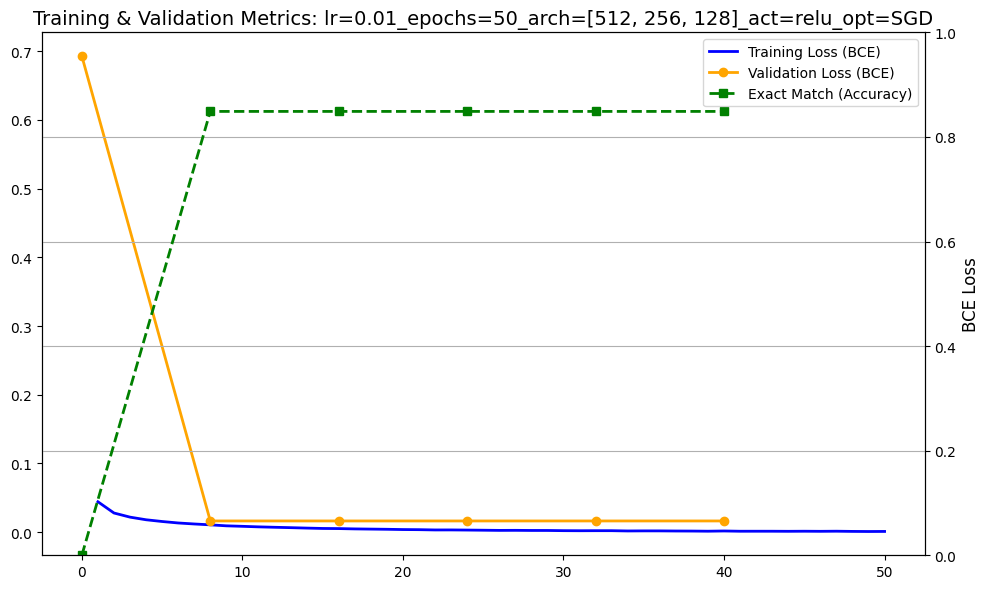


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=tanh_opt=Batch
Epoch 10/50, Loss: 0.6076
Epoch 20/50, Loss: 0.3339
Epoch 30/50, Loss: 0.1303
Epoch 40/50, Loss: 0.0856
Epoch 50/50, Loss: 0.0707
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0699
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0700
Training time: 1.91 seconds


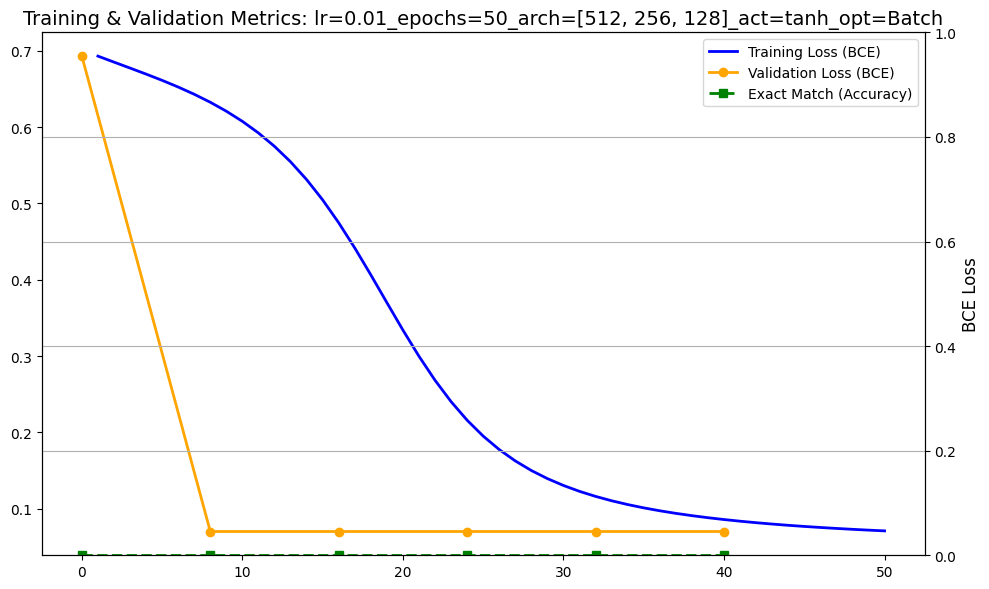


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/50, Loss: 0.0489
Epoch 20/50, Loss: 0.0418
Epoch 30/50, Loss: 0.0381
Epoch 40/50, Loss: 0.0326
Epoch 50/50, Loss: 0.0283
Validation metrics: Hamming Loss=0.0074, Exact Match=0.5495, BCE Loss=0.0294
Test metrics: Hamming Loss=0.0073, Exact Match=0.5701, BCE Loss=0.0306
Training time: 15.56 seconds


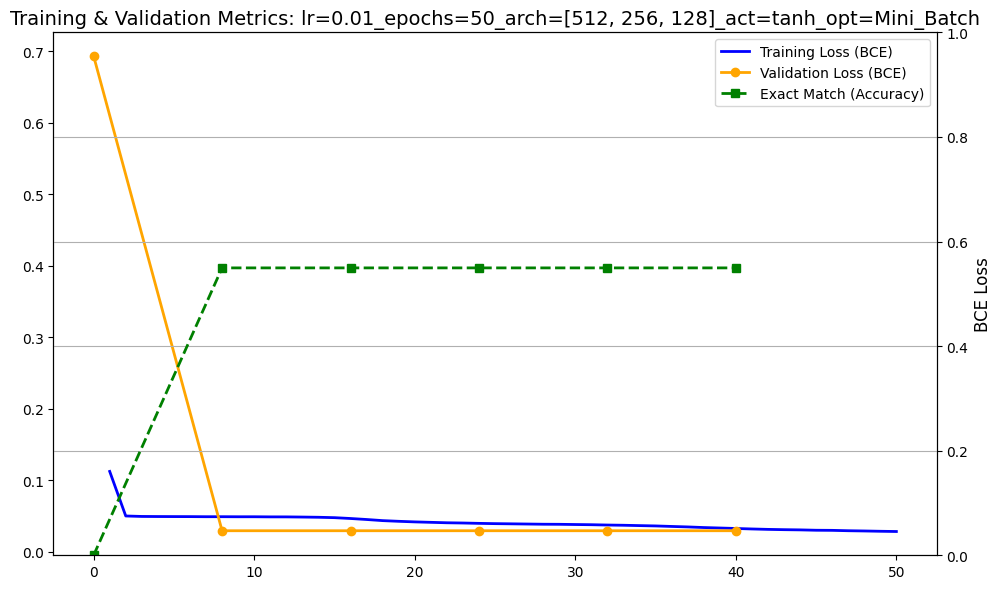


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=tanh_opt=SGD
Epoch 10/50, Loss: 0.0140
Epoch 20/50, Loss: 0.0076
Epoch 30/50, Loss: 0.0043
Epoch 40/50, Loss: 0.0027
Epoch 50/50, Loss: 0.0019
Validation metrics: Hamming Loss=0.0034, Exact Match=0.8243, BCE Loss=0.0149
Test metrics: Hamming Loss=0.0044, Exact Match=0.7844, BCE Loss=0.0202
Training time: 449.34 seconds


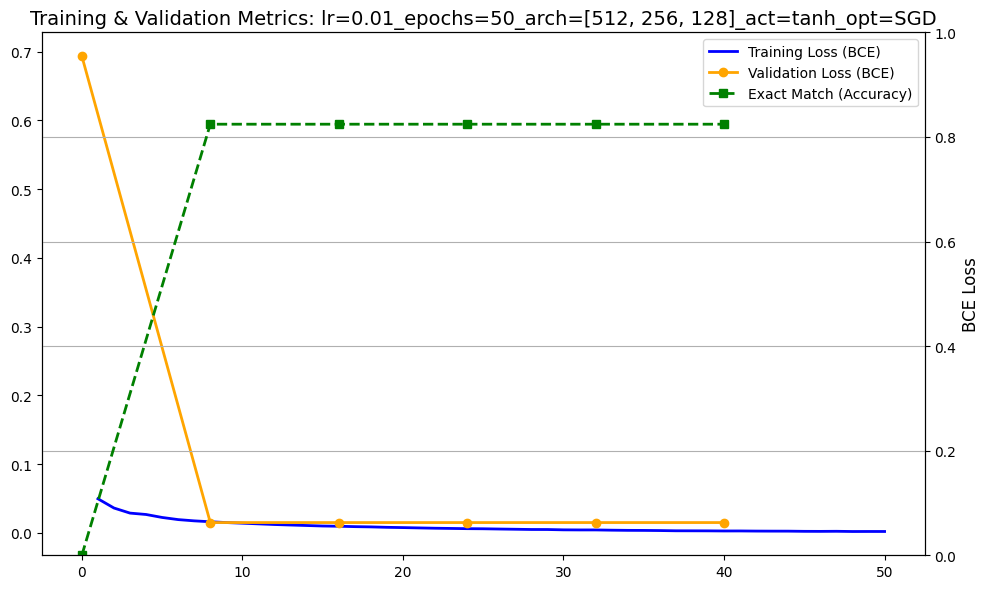


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=sigmoid_opt=Batch
Epoch 10/50, Loss: 0.2623
Epoch 20/50, Loss: 0.1267
Epoch 30/50, Loss: 0.0889
Epoch 40/50, Loss: 0.0738
Epoch 50/50, Loss: 0.0662
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0659
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0659
Training time: 2.00 seconds


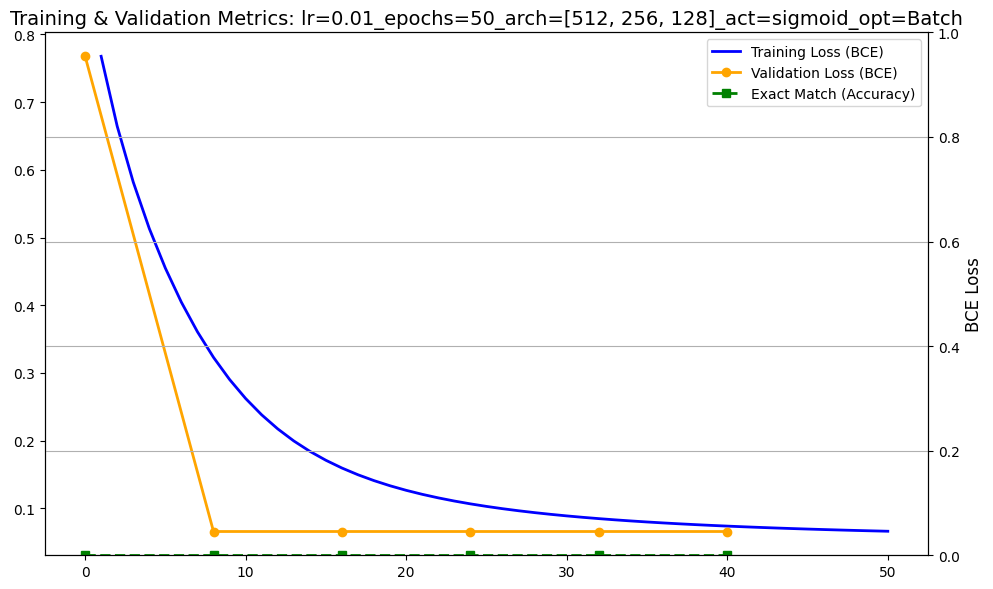


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/50, Loss: 0.0491
Epoch 20/50, Loss: 0.0493
Epoch 30/50, Loss: 0.0491
Epoch 40/50, Loss: 0.0492
Epoch 50/50, Loss: 0.0490
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0492
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0502
Training time: 18.22 seconds


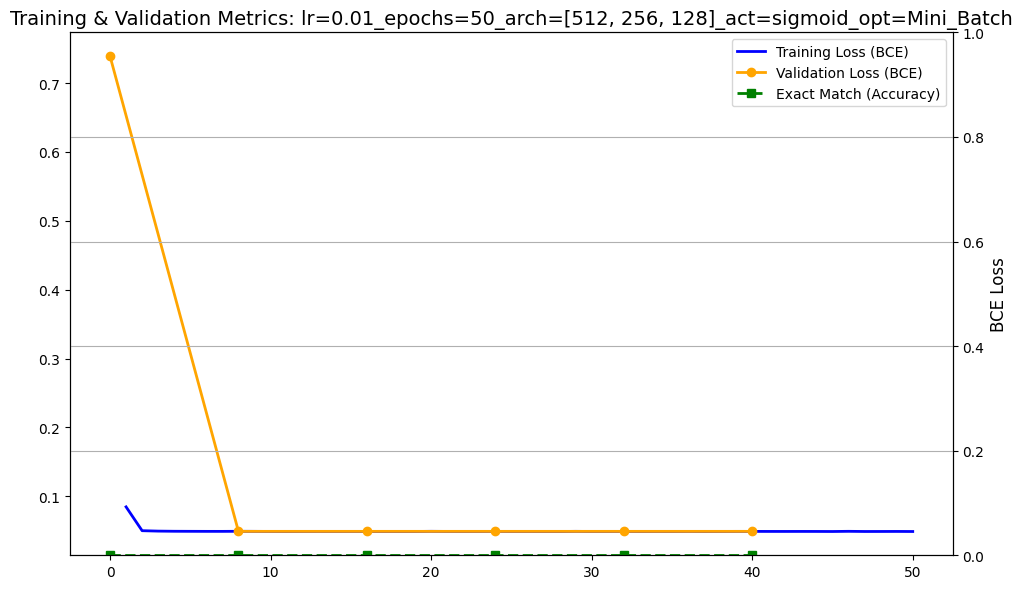


Training with lr=0.01_epochs=50_arch=[512, 256, 128]_act=sigmoid_opt=SGD
Epoch 10/50, Loss: 0.0496
Epoch 20/50, Loss: 0.0494
Epoch 30/50, Loss: 0.0414
Epoch 40/50, Loss: 0.0331
Epoch 50/50, Loss: 0.0281
Validation metrics: Hamming Loss=0.0079, Exact Match=0.5270, BCE Loss=0.0292
Test metrics: Hamming Loss=0.0078, Exact Match=0.5472, BCE Loss=0.0303
Training time: 540.83 seconds


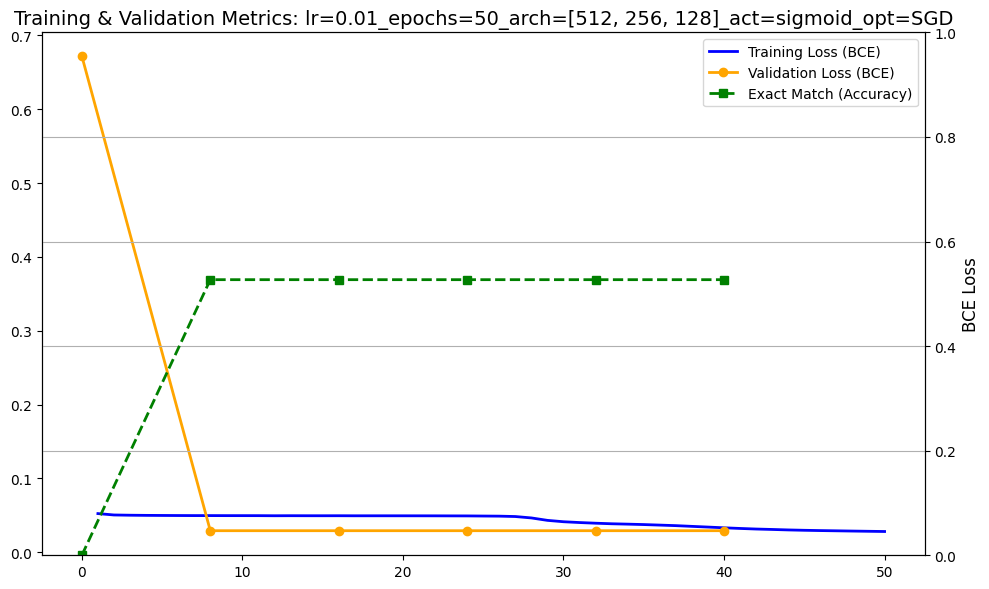


Training with lr=0.01_epochs=100_arch=[256, 128]_act=relu_opt=Batch
Epoch 10/100, Loss: 0.6596
Epoch 20/100, Loss: 0.5987
Epoch 30/100, Loss: 0.4544
Epoch 40/100, Loss: 0.1961
Epoch 50/100, Loss: 0.0861
Epoch 60/100, Loss: 0.0633
Epoch 70/100, Loss: 0.0565
Epoch 80/100, Loss: 0.0536
Epoch 90/100, Loss: 0.0521
Epoch 100/100, Loss: 0.0512
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0513
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0514
Training time: 2.25 seconds


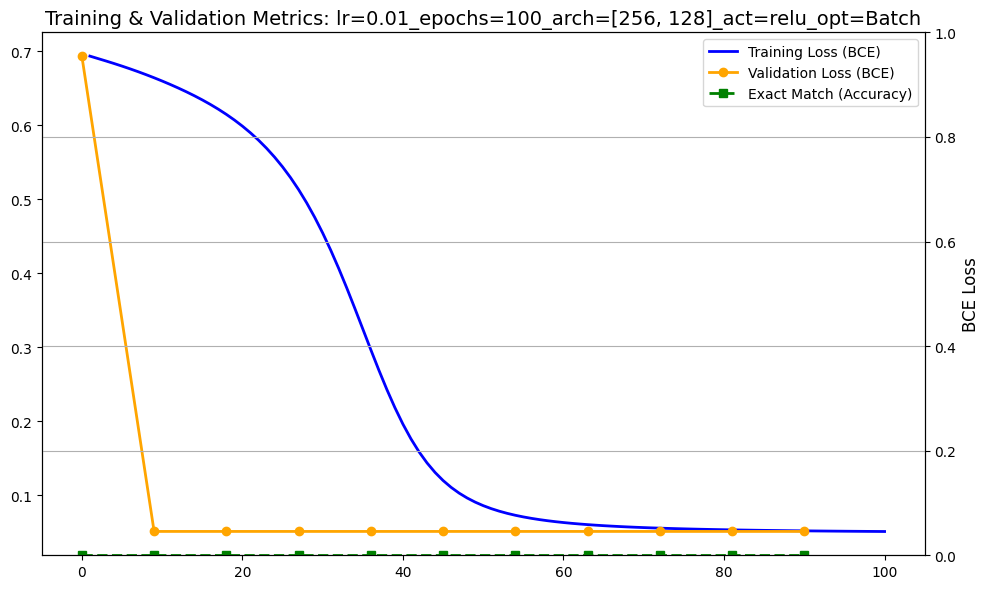


Training with lr=0.01_epochs=100_arch=[256, 128]_act=relu_opt=Mini_Batch
Epoch 10/100, Loss: 0.0432
Epoch 20/100, Loss: 0.0381
Epoch 30/100, Loss: 0.0334
Epoch 40/100, Loss: 0.0295
Epoch 50/100, Loss: 0.0270
Epoch 60/100, Loss: 0.0249
Epoch 70/100, Loss: 0.0230
Epoch 80/100, Loss: 0.0215
Epoch 90/100, Loss: 0.0201
Epoch 100/100, Loss: 0.0190
Validation metrics: Hamming Loss=0.0054, Exact Match=0.6615, BCE Loss=0.0203
Test metrics: Hamming Loss=0.0058, Exact Match=0.6625, BCE Loss=0.0224
Training time: 26.47 seconds


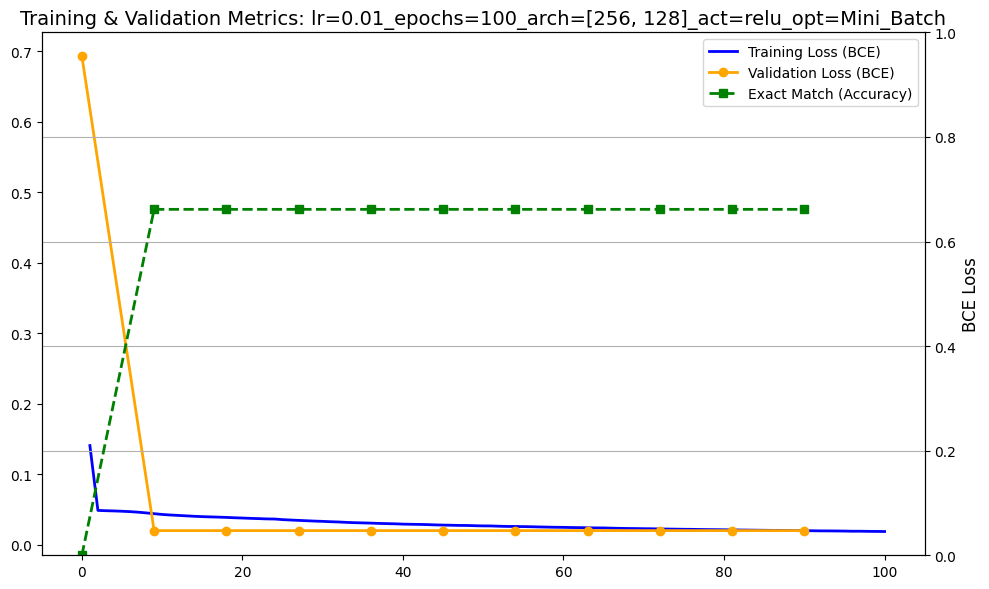


Training with lr=0.01_epochs=100_arch=[256, 128]_act=relu_opt=SGD
Epoch 10/100, Loss: 0.0095
Epoch 20/100, Loss: 0.0041
Epoch 30/100, Loss: 0.0022
Epoch 40/100, Loss: 0.0015
Epoch 50/100, Loss: 0.0011
Epoch 60/100, Loss: 0.0009
Epoch 70/100, Loss: 0.0008
Epoch 80/100, Loss: 0.0007
Epoch 90/100, Loss: 0.0006
Epoch 100/100, Loss: 0.0006
Validation metrics: Hamming Loss=0.0032, Exact Match=0.8301, BCE Loss=0.0195
Test metrics: Hamming Loss=0.0040, Exact Match=0.7890, BCE Loss=0.0249
Training time: 790.16 seconds


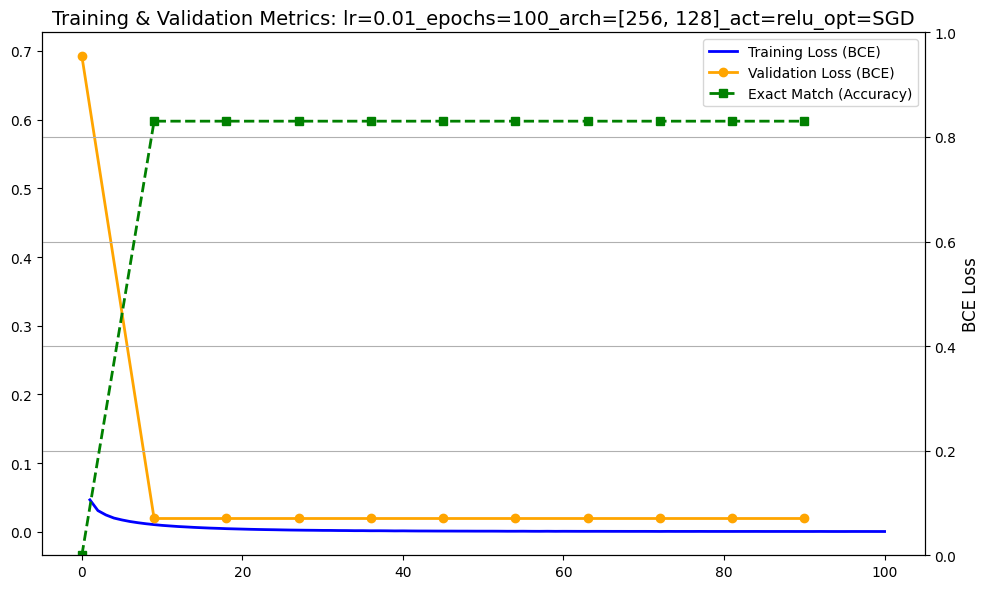


Training with lr=0.01_epochs=100_arch=[256, 128]_act=tanh_opt=Batch
Epoch 10/100, Loss: 0.6269
Epoch 20/100, Loss: 0.4856
Epoch 30/100, Loss: 0.2620
Epoch 40/100, Loss: 0.1396
Epoch 50/100, Loss: 0.0962
Epoch 60/100, Loss: 0.0782
Epoch 70/100, Loss: 0.0690
Epoch 80/100, Loss: 0.0638
Epoch 90/100, Loss: 0.0604
Epoch 100/100, Loss: 0.0581
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0581
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0582
Training time: 2.35 seconds


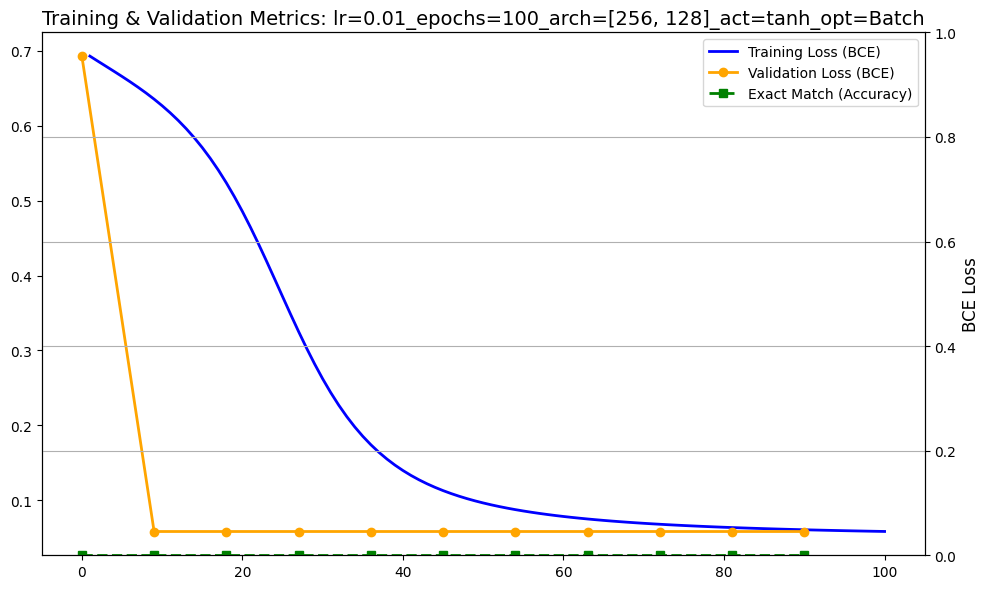


Training with lr=0.01_epochs=100_arch=[256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/100, Loss: 0.0480
Epoch 20/100, Loss: 0.0415
Epoch 30/100, Loss: 0.0387
Epoch 40/100, Loss: 0.0352
Epoch 50/100, Loss: 0.0317
Epoch 60/100, Loss: 0.0292
Epoch 70/100, Loss: 0.0274
Epoch 80/100, Loss: 0.0260
Epoch 90/100, Loss: 0.0244
Epoch 100/100, Loss: 0.0232
Validation metrics: Hamming Loss=0.0064, Exact Match=0.5952, BCE Loss=0.0247
Test metrics: Hamming Loss=0.0066, Exact Match=0.6191, BCE Loss=0.0259
Training time: 23.71 seconds


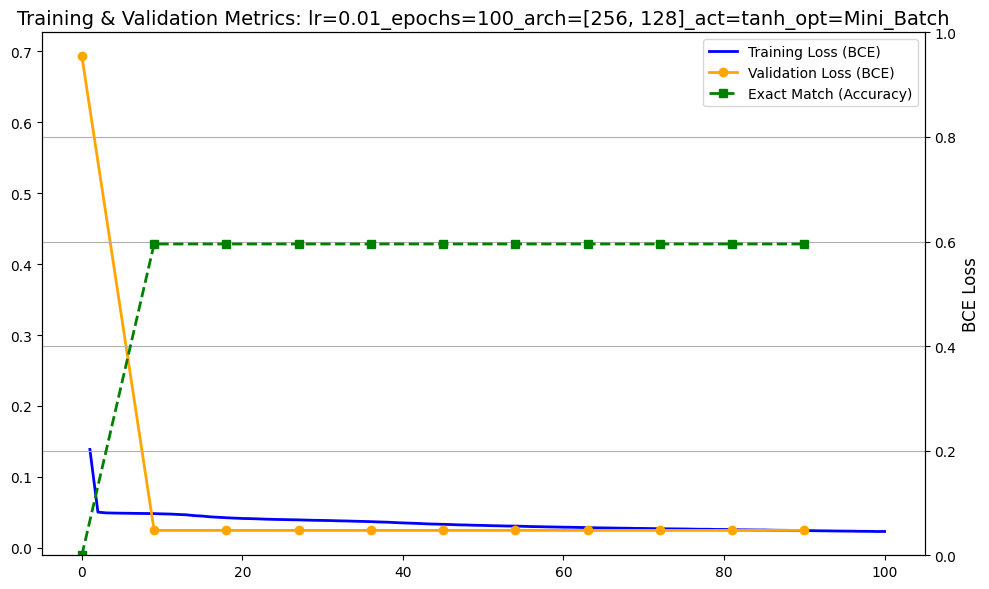


Training with lr=0.01_epochs=100_arch=[256, 128]_act=tanh_opt=SGD
Epoch 10/100, Loss: 0.0110
Epoch 20/100, Loss: 0.0050
Epoch 30/100, Loss: 0.0027
Epoch 40/100, Loss: 0.0018
Epoch 50/100, Loss: 0.0013
Epoch 60/100, Loss: 0.0010
Epoch 70/100, Loss: 0.0009
Epoch 80/100, Loss: 0.0008
Epoch 90/100, Loss: 0.0007
Epoch 100/100, Loss: 0.0006
Validation metrics: Hamming Loss=0.0030, Exact Match=0.8359, BCE Loss=0.0160
Test metrics: Hamming Loss=0.0040, Exact Match=0.7940, BCE Loss=0.0217
Training time: 700.10 seconds


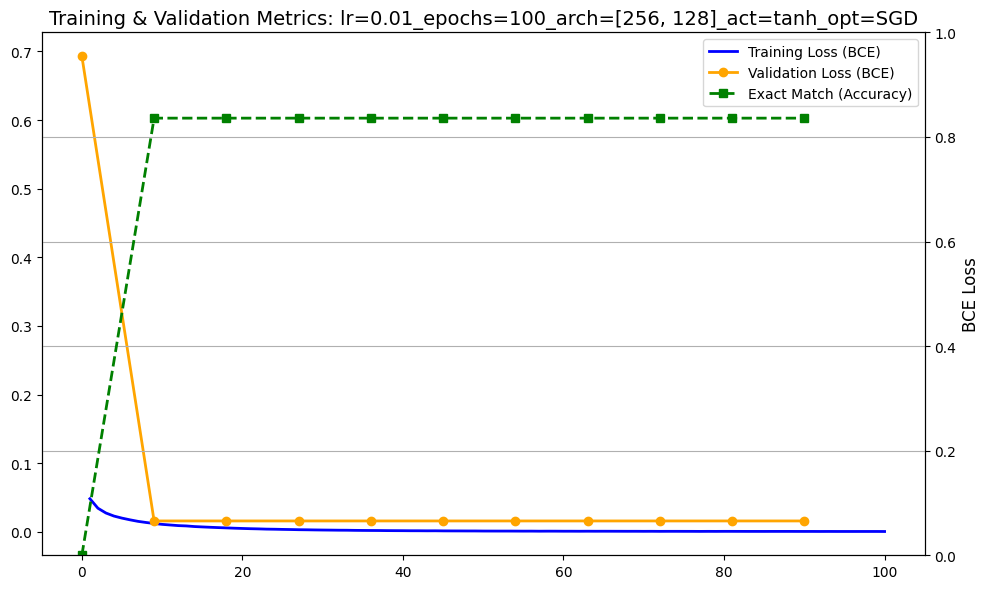


Training with lr=0.01_epochs=100_arch=[256, 128]_act=sigmoid_opt=Batch
Epoch 10/100, Loss: 0.2521
Epoch 20/100, Loss: 0.1283
Epoch 30/100, Loss: 0.0912
Epoch 40/100, Loss: 0.0757
Epoch 50/100, Loss: 0.0677
Epoch 60/100, Loss: 0.0630
Epoch 70/100, Loss: 0.0600
Epoch 80/100, Loss: 0.0579
Epoch 90/100, Loss: 0.0563
Epoch 100/100, Loss: 0.0552
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0553
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0554
Training time: 2.35 seconds


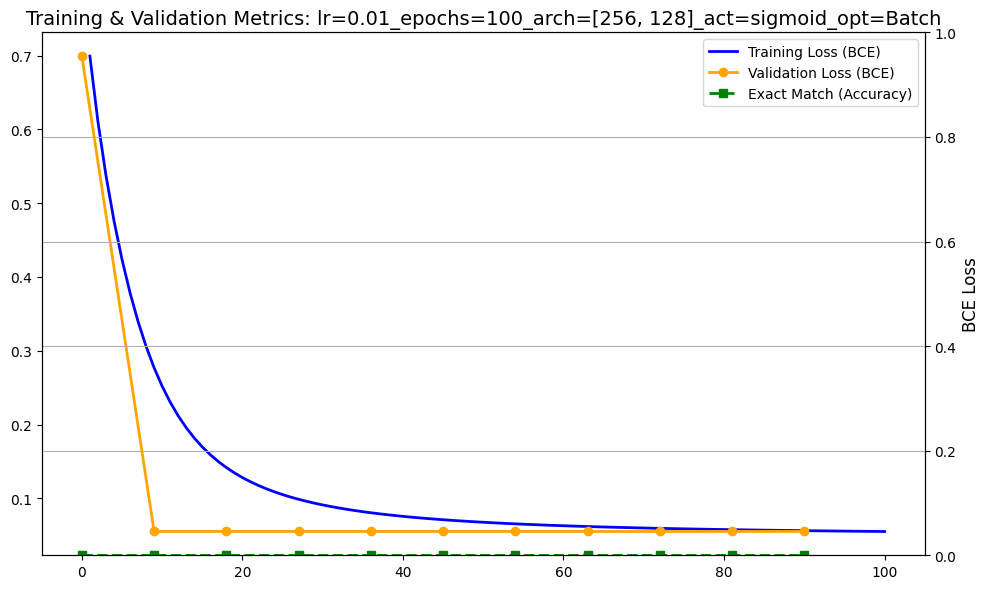


Training with lr=0.01_epochs=100_arch=[256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/100, Loss: 0.0491
Epoch 20/100, Loss: 0.0491
Epoch 30/100, Loss: 0.0491
Epoch 40/100, Loss: 0.0490
Epoch 50/100, Loss: 0.0491
Epoch 60/100, Loss: 0.0490
Epoch 70/100, Loss: 0.0490
Epoch 80/100, Loss: 0.0490
Epoch 90/100, Loss: 0.0490
Epoch 100/100, Loss: 0.0490
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0491
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0500
Training time: 28.57 seconds


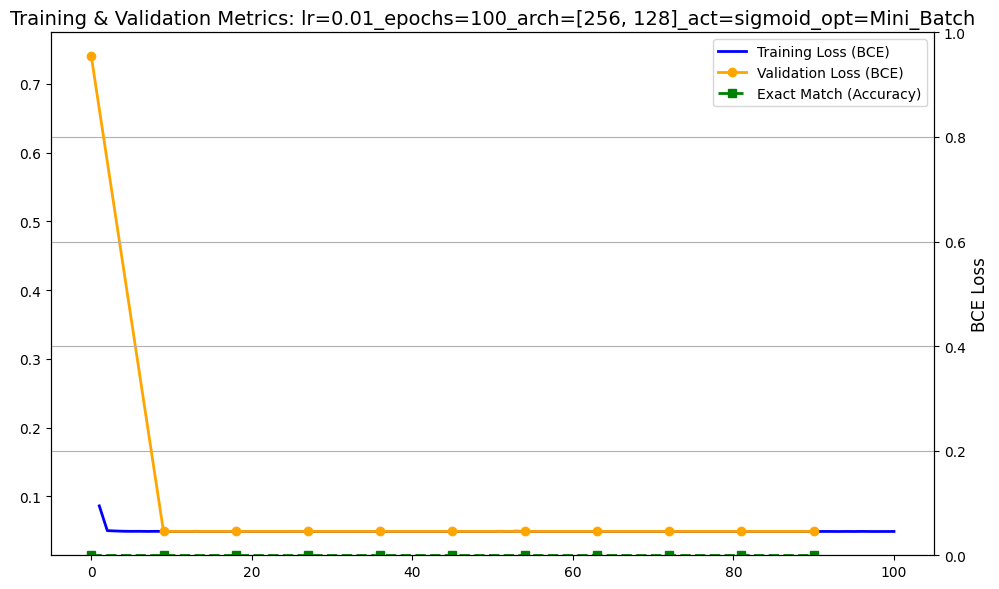


Training with lr=0.01_epochs=100_arch=[256, 128]_act=sigmoid_opt=SGD
Epoch 10/100, Loss: 0.0420
Epoch 20/100, Loss: 0.0348
Epoch 30/100, Loss: 0.0285
Epoch 40/100, Loss: 0.0239
Epoch 50/100, Loss: 0.0207
Epoch 60/100, Loss: 0.0180
Epoch 70/100, Loss: 0.0161
Epoch 80/100, Loss: 0.0147
Epoch 90/100, Loss: 0.0134
Epoch 100/100, Loss: 0.0121
Validation metrics: Hamming Loss=0.0048, Exact Match=0.7207, BCE Loss=0.0167
Test metrics: Hamming Loss=0.0054, Exact Match=0.7006, BCE Loss=0.0197
Training time: 854.41 seconds


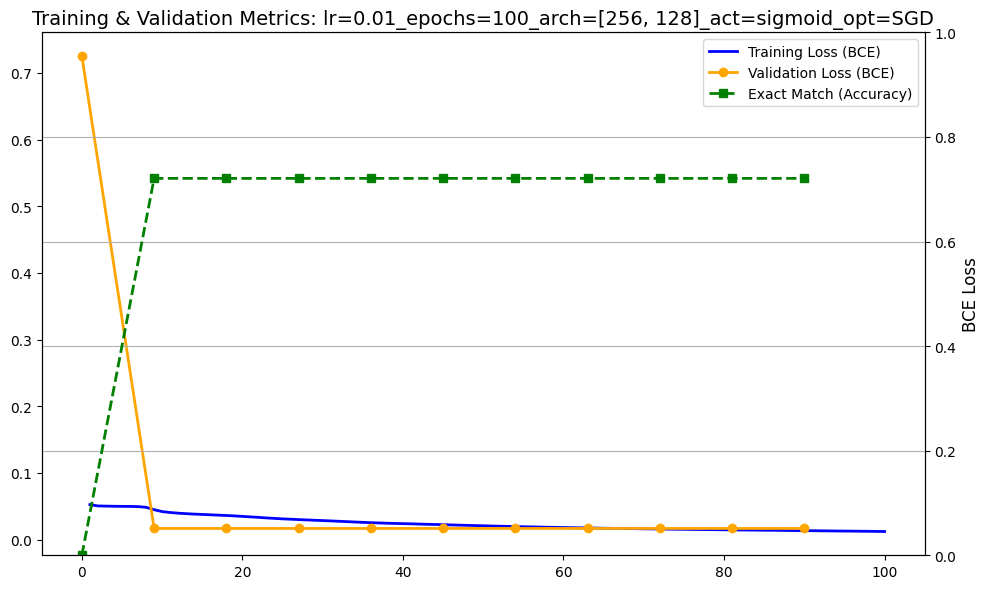


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=relu_opt=Batch
Epoch 10/100, Loss: 0.6495
Epoch 20/100, Loss: 0.4988
Epoch 30/100, Loss: 0.0980
Epoch 40/100, Loss: 0.0559
Epoch 50/100, Loss: 0.0519
Epoch 60/100, Loss: 0.0507
Epoch 70/100, Loss: 0.0501
Epoch 80/100, Loss: 0.0497
Epoch 90/100, Loss: 0.0494
Epoch 100/100, Loss: 0.0493
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0494
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0499
Training time: 3.97 seconds


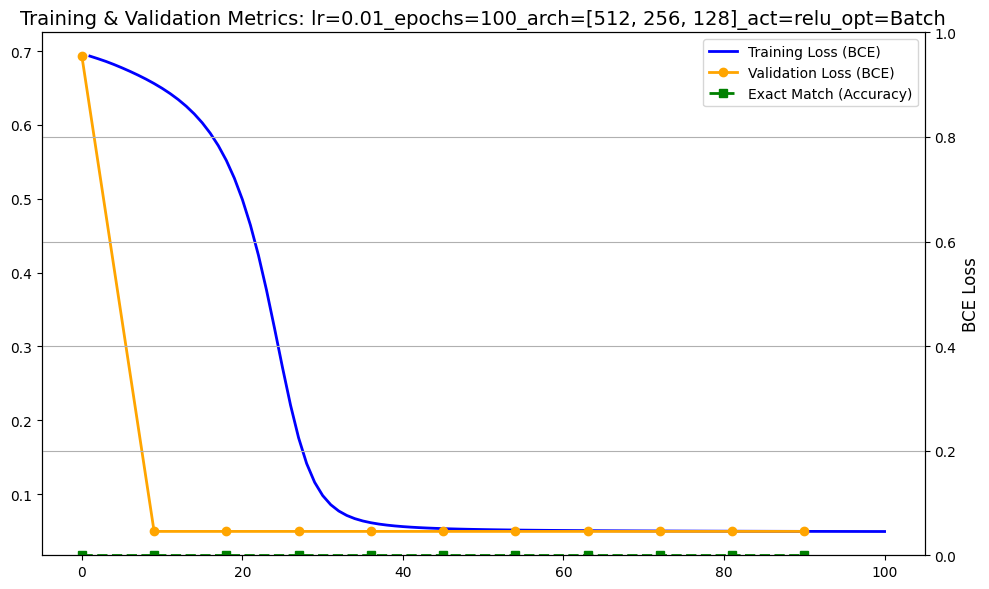


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=relu_opt=Mini_Batch
Epoch 10/100, Loss: 0.0400
Epoch 20/100, Loss: 0.0319
Epoch 30/100, Loss: 0.0267
Epoch 40/100, Loss: 0.0229
Epoch 50/100, Loss: 0.0197
Epoch 60/100, Loss: 0.0173
Epoch 70/100, Loss: 0.0153
Epoch 80/100, Loss: 0.0136
Epoch 90/100, Loss: 0.0122
Epoch 100/100, Loss: 0.0110
Validation metrics: Hamming Loss=0.0044, Exact Match=0.7336, BCE Loss=0.0161
Test metrics: Hamming Loss=0.0051, Exact Match=0.7088, BCE Loss=0.0193
Training time: 32.81 seconds


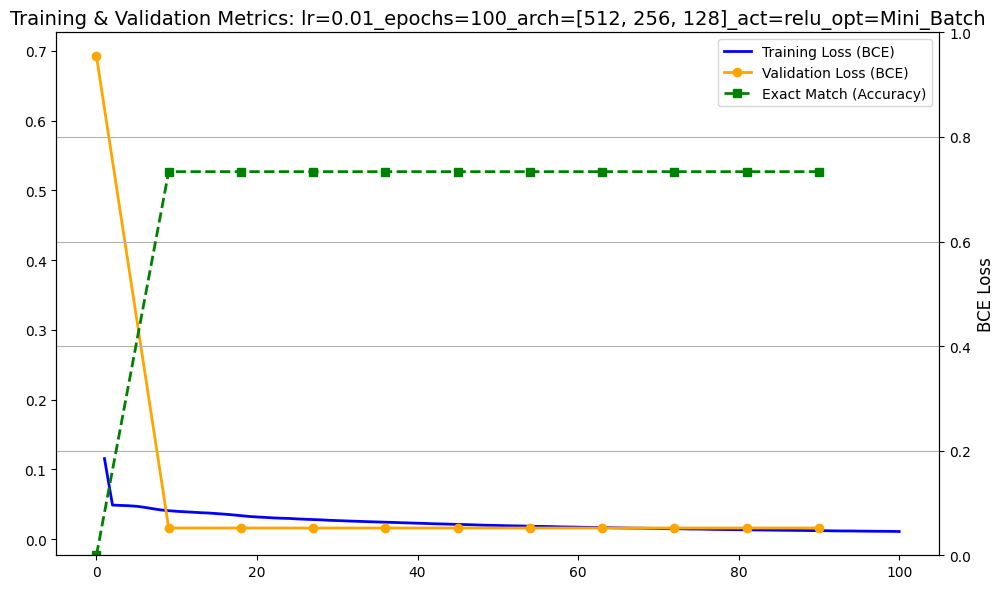


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=relu_opt=SGD
Epoch 10/100, Loss: 0.0079
Epoch 20/100, Loss: 0.0037
Epoch 30/100, Loss: 0.0022
Epoch 40/100, Loss: 0.0017
Epoch 50/100, Loss: 0.0011
Epoch 60/100, Loss: 0.0007
Epoch 70/100, Loss: 0.0006
Epoch 80/100, Loss: 0.0005
Epoch 90/100, Loss: 0.0005
Epoch 100/100, Loss: 0.0004
Validation metrics: Hamming Loss=0.0030, Exact Match=0.8366, BCE Loss=0.0211
Test metrics: Hamming Loss=0.0041, Exact Match=0.7946, BCE Loss=0.0282
Training time: 963.85 seconds


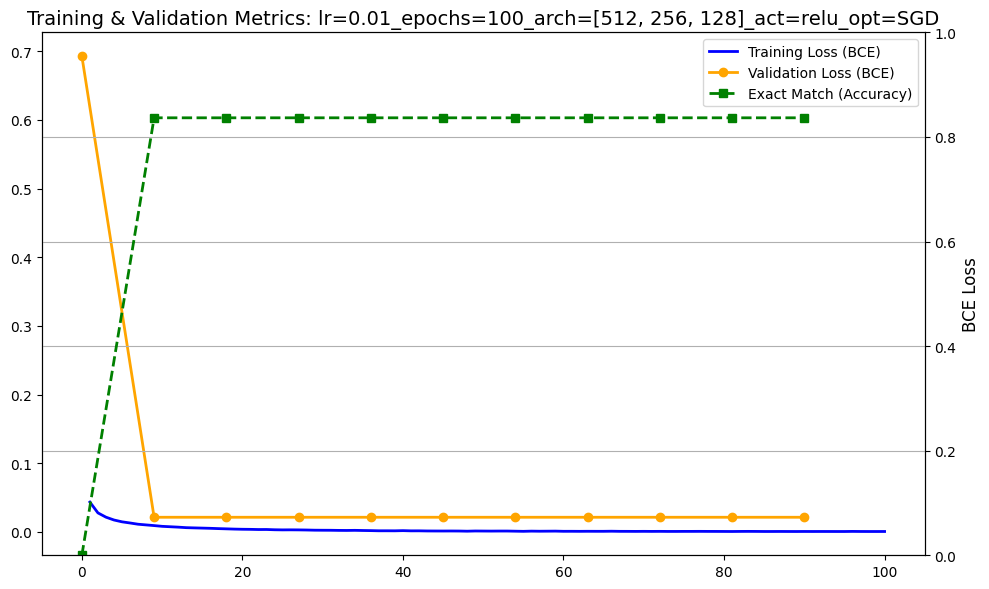


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=tanh_opt=Batch
Epoch 10/100, Loss: 0.5608
Epoch 20/100, Loss: 0.2353
Epoch 30/100, Loss: 0.1101
Epoch 40/100, Loss: 0.0801
Epoch 50/100, Loss: 0.0685
Epoch 60/100, Loss: 0.0627
Epoch 70/100, Loss: 0.0593
Epoch 80/100, Loss: 0.0571
Epoch 90/100, Loss: 0.0556
Epoch 100/100, Loss: 0.0544
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0545
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0547
Training time: 3.87 seconds


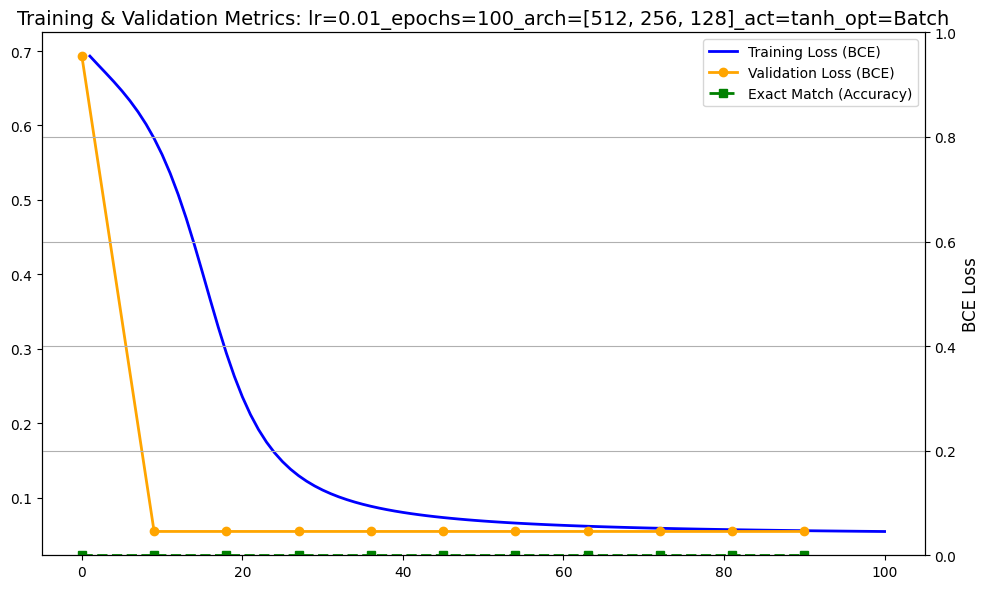


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/100, Loss: 0.0487
Epoch 20/100, Loss: 0.0409
Epoch 30/100, Loss: 0.0372
Epoch 40/100, Loss: 0.0313
Epoch 50/100, Loss: 0.0278
Epoch 60/100, Loss: 0.0252
Epoch 70/100, Loss: 0.0232
Epoch 80/100, Loss: 0.0212
Epoch 90/100, Loss: 0.0196
Epoch 100/100, Loss: 0.0183
Validation metrics: Hamming Loss=0.0059, Exact Match=0.6358, BCE Loss=0.0210
Test metrics: Hamming Loss=0.0061, Exact Match=0.6522, BCE Loss=0.0229
Training time: 31.03 seconds


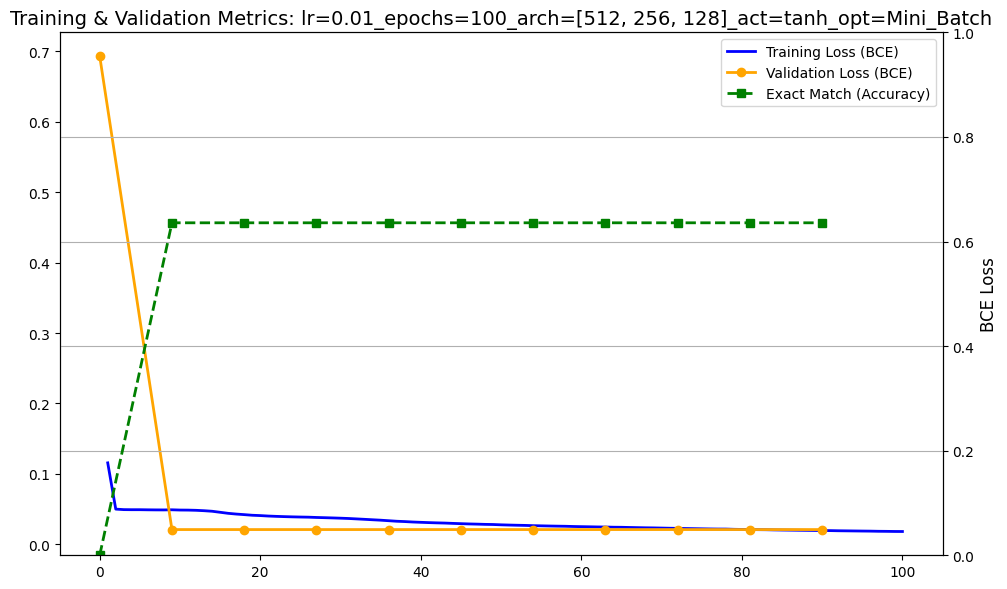


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=tanh_opt=SGD
Epoch 10/100, Loss: 0.0095
Epoch 20/100, Loss: 0.0044
Epoch 30/100, Loss: 0.0024
Epoch 40/100, Loss: 0.0014
Epoch 50/100, Loss: 0.0009
Epoch 60/100, Loss: 0.0007
Epoch 70/100, Loss: 0.0006
Epoch 80/100, Loss: 0.0006
Epoch 90/100, Loss: 0.0005
Epoch 100/100, Loss: 0.0005
Validation metrics: Hamming Loss=0.0032, Exact Match=0.8314, BCE Loss=0.0163
Test metrics: Hamming Loss=0.0041, Exact Match=0.7917, BCE Loss=0.0233
Training time: 897.85 seconds


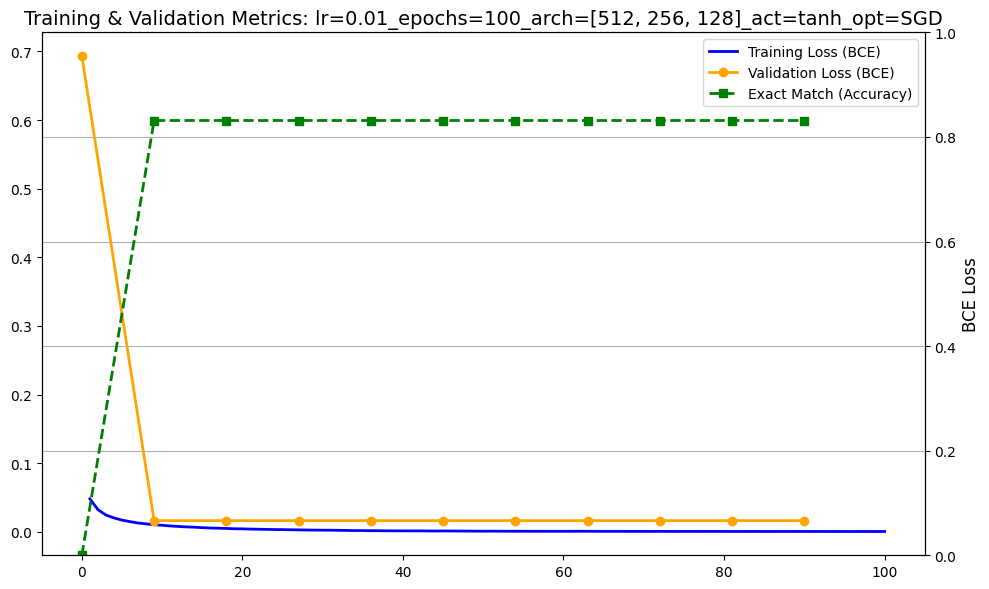


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=sigmoid_opt=Batch
Epoch 10/100, Loss: 0.2486
Epoch 20/100, Loss: 0.1239
Epoch 30/100, Loss: 0.0881
Epoch 40/100, Loss: 0.0735
Epoch 50/100, Loss: 0.0661
Epoch 60/100, Loss: 0.0617
Epoch 70/100, Loss: 0.0589
Epoch 80/100, Loss: 0.0570
Epoch 90/100, Loss: 0.0556
Epoch 100/100, Loss: 0.0546
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0547
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0548
Training time: 4.04 seconds


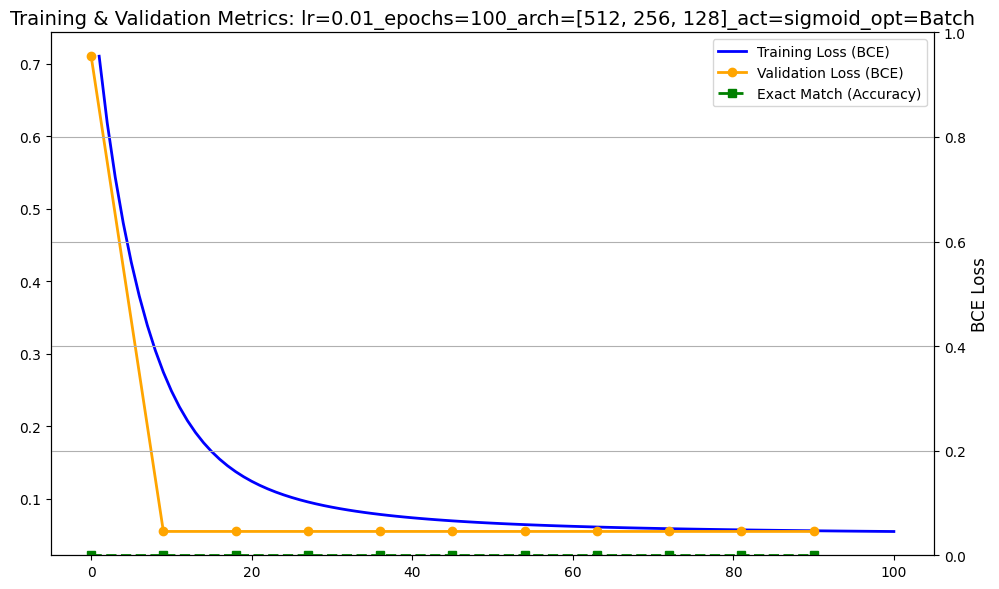


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/100, Loss: 0.0492
Epoch 20/100, Loss: 0.0491
Epoch 30/100, Loss: 0.0490
Epoch 40/100, Loss: 0.0491
Epoch 50/100, Loss: 0.0491
Epoch 60/100, Loss: 0.0490
Epoch 70/100, Loss: 0.0491
Epoch 80/100, Loss: 0.0490
Epoch 90/100, Loss: 0.0491
Epoch 100/100, Loss: 0.0490
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0493
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0500
Training time: 36.26 seconds


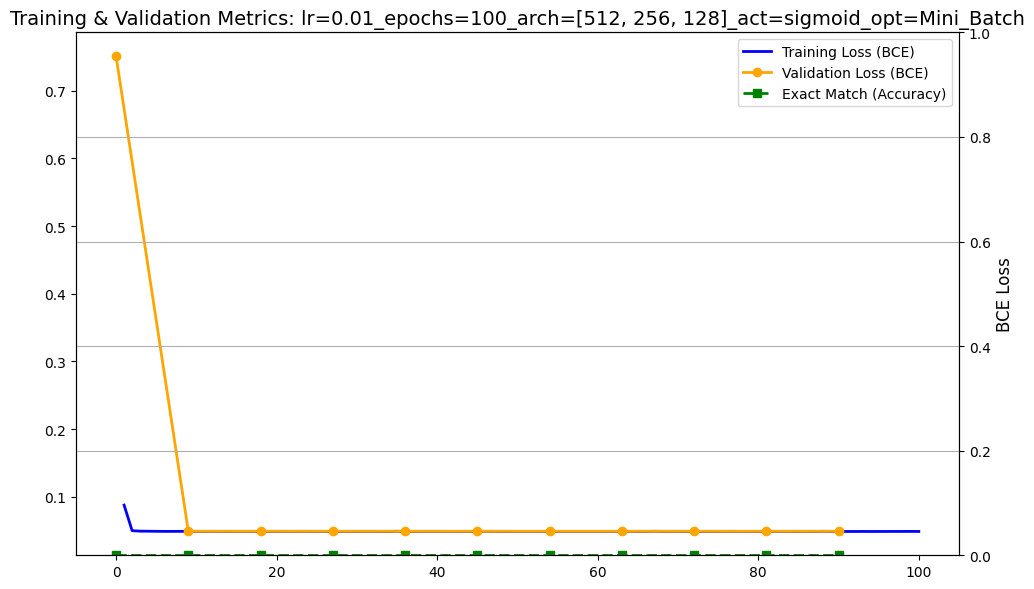


Training with lr=0.01_epochs=100_arch=[512, 256, 128]_act=sigmoid_opt=SGD
Epoch 10/100, Loss: 0.0496
Epoch 20/100, Loss: 0.0494
Epoch 30/100, Loss: 0.0406
Epoch 40/100, Loss: 0.0320
Epoch 50/100, Loss: 0.0279
Epoch 60/100, Loss: 0.0261
Epoch 70/100, Loss: 0.0247
Epoch 80/100, Loss: 0.0237
Epoch 90/100, Loss: 0.0229
Epoch 100/100, Loss: 0.0223
Validation metrics: Hamming Loss=0.0084, Exact Match=0.5225, BCE Loss=0.0327
Test metrics: Hamming Loss=0.0089, Exact Match=0.5277, BCE Loss=0.0357
Training time: 1083.68 seconds


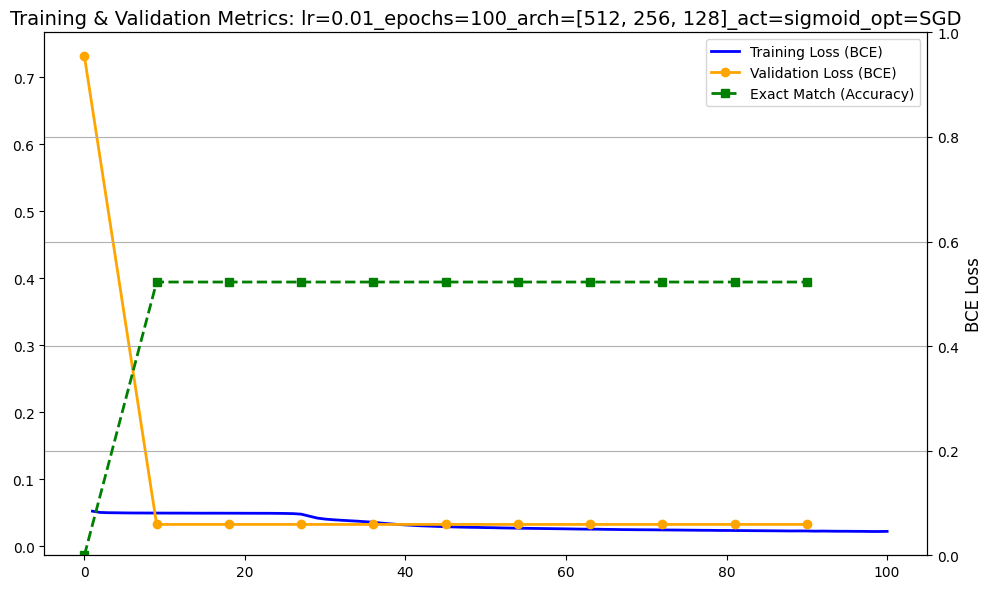


Training with lr=0.05_epochs=50_arch=[256, 128]_act=relu_opt=Batch
Epoch 10/50, Loss: 0.1631
Epoch 20/50, Loss: 0.0513
Epoch 30/50, Loss: 0.0496
Epoch 40/50, Loss: 0.0491
Epoch 50/50, Loss: 0.0489
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0490
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0496
Training time: 1.20 seconds


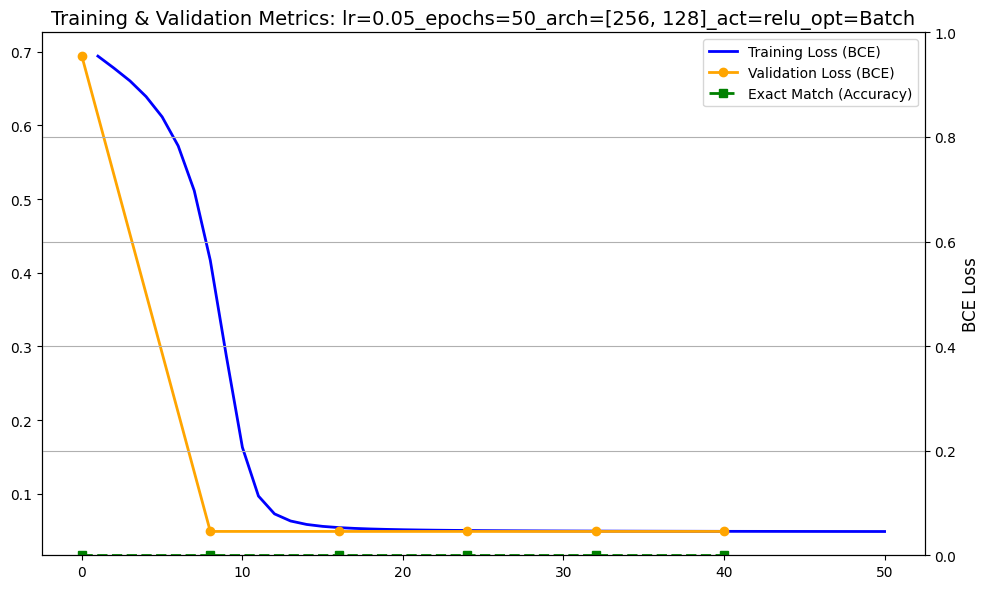


Training with lr=0.05_epochs=50_arch=[256, 128]_act=relu_opt=Mini_Batch
Epoch 10/50, Loss: 0.0285
Epoch 20/50, Loss: 0.0198
Epoch 30/50, Loss: 0.0149
Epoch 40/50, Loss: 0.0115
Epoch 50/50, Loss: 0.0092
Validation metrics: Hamming Loss=0.0039, Exact Match=0.7690, BCE Loss=0.0134
Test metrics: Hamming Loss=0.0045, Exact Match=0.7440, BCE Loss=0.0162
Training time: 13.26 seconds


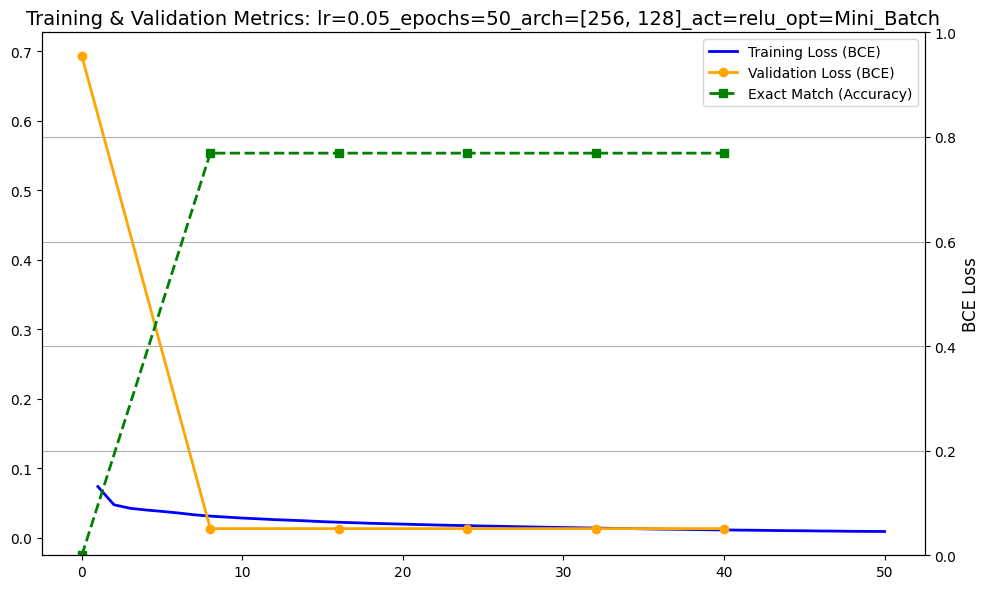


Training with lr=0.05_epochs=50_arch=[256, 128]_act=relu_opt=SGD
Epoch 10/50, Loss: 0.0066
Epoch 20/50, Loss: 0.0031
Epoch 30/50, Loss: 0.0017
Epoch 40/50, Loss: 0.0014
Epoch 50/50, Loss: 0.0009
Validation metrics: Hamming Loss=0.0029, Exact Match=0.8494, BCE Loss=0.0195
Test metrics: Hamming Loss=0.0037, Exact Match=0.8069, BCE Loss=0.0240
Training time: 395.12 seconds


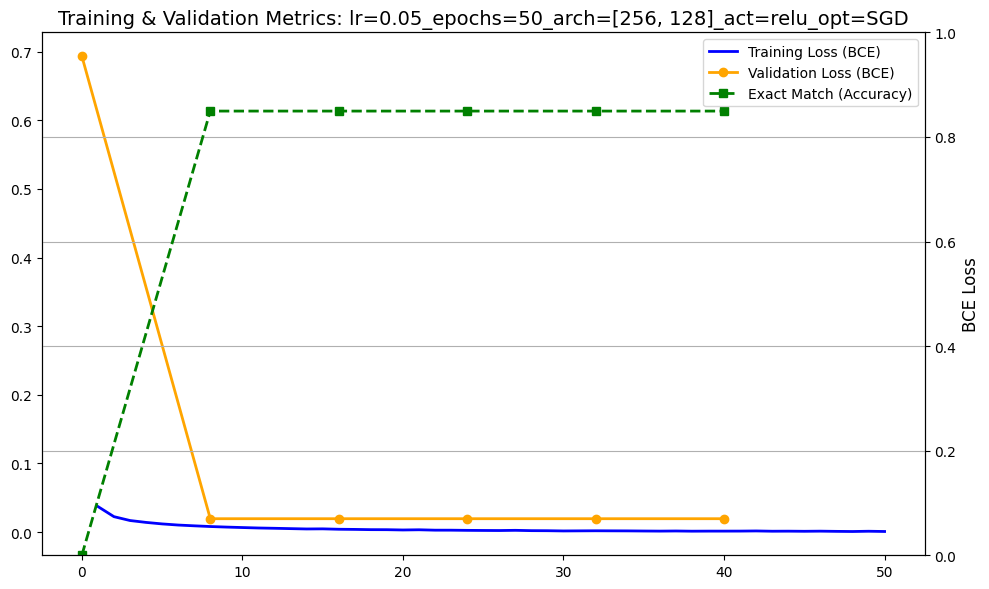


Training with lr=0.05_epochs=50_arch=[256, 128]_act=tanh_opt=Batch
Epoch 10/50, Loss: 0.1149
Epoch 20/50, Loss: 0.0594
Epoch 30/50, Loss: 0.0535
Epoch 40/50, Loss: 0.0516
Epoch 50/50, Loss: 0.0507
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0508
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0511
Training time: 1.18 seconds


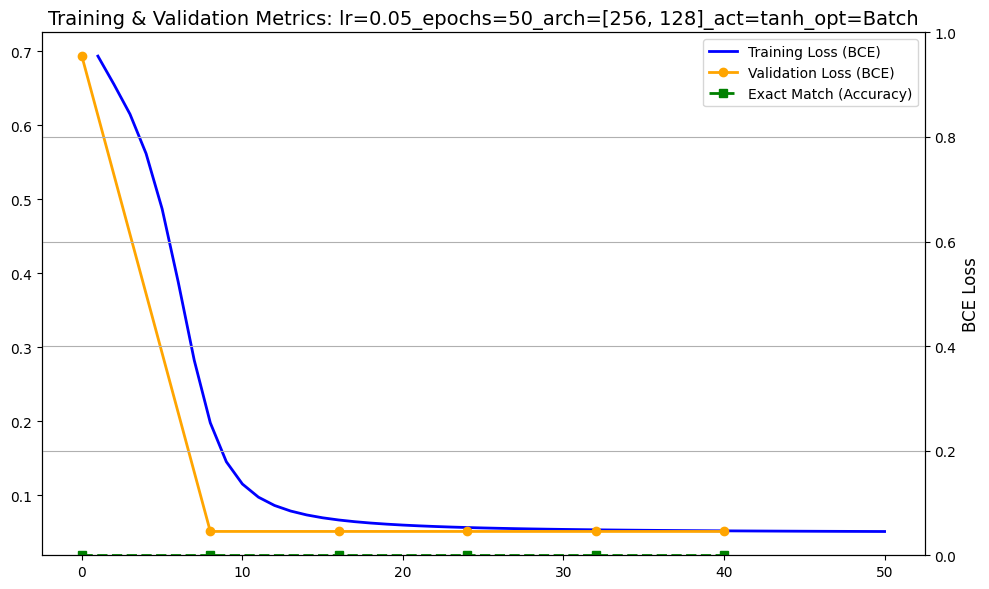


Training with lr=0.05_epochs=50_arch=[256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/50, Loss: 0.0326
Epoch 20/50, Loss: 0.0236
Epoch 30/50, Loss: 0.0184
Epoch 40/50, Loss: 0.0144
Epoch 50/50, Loss: 0.0117
Validation metrics: Hamming Loss=0.0045, Exact Match=0.7362, BCE Loss=0.0155
Test metrics: Hamming Loss=0.0050, Exact Match=0.7168, BCE Loss=0.0182
Training time: 11.93 seconds


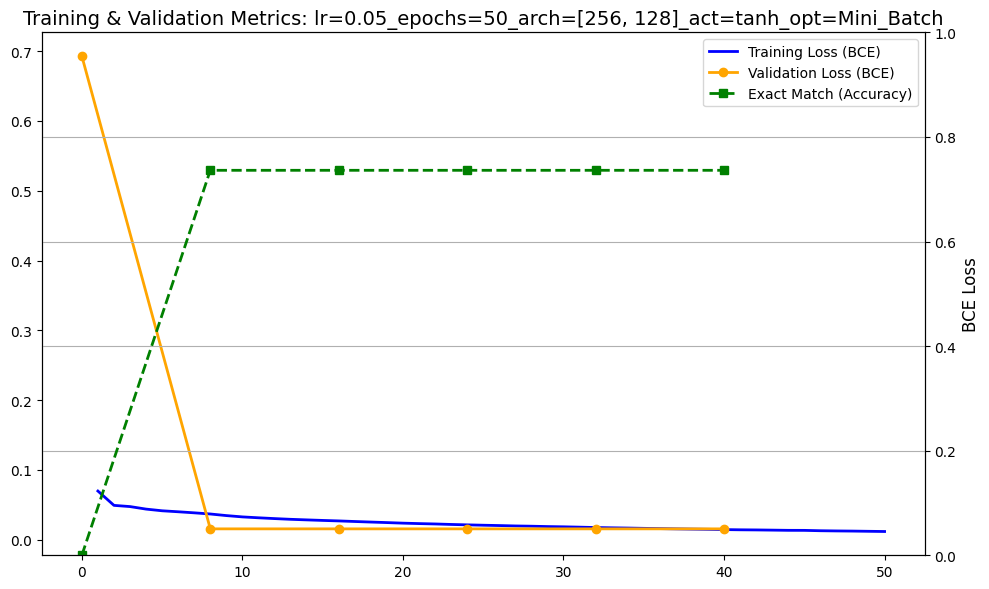


Training with lr=0.05_epochs=50_arch=[256, 128]_act=tanh_opt=SGD
Epoch 10/50, Loss: 0.0047
Epoch 20/50, Loss: 0.0017
Epoch 30/50, Loss: 0.0010
Epoch 40/50, Loss: 0.0009
Epoch 50/50, Loss: 0.0006
Validation metrics: Hamming Loss=0.0027, Exact Match=0.8526, BCE Loss=0.0165
Test metrics: Hamming Loss=0.0037, Exact Match=0.8142, BCE Loss=0.0221
Training time: 351.70 seconds


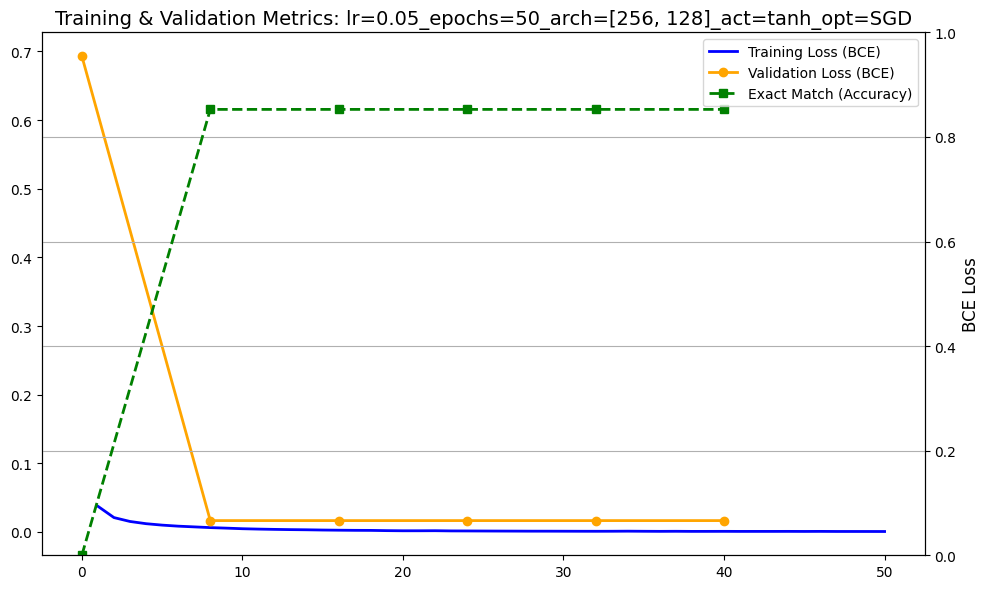


Training with lr=0.05_epochs=50_arch=[256, 128]_act=sigmoid_opt=Batch
Epoch 10/50, Loss: 0.0683
Epoch 20/50, Loss: 0.0552
Epoch 30/50, Loss: 0.0522
Epoch 40/50, Loss: 0.0510
Epoch 50/50, Loss: 0.0504
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0505
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0509
Training time: 1.21 seconds


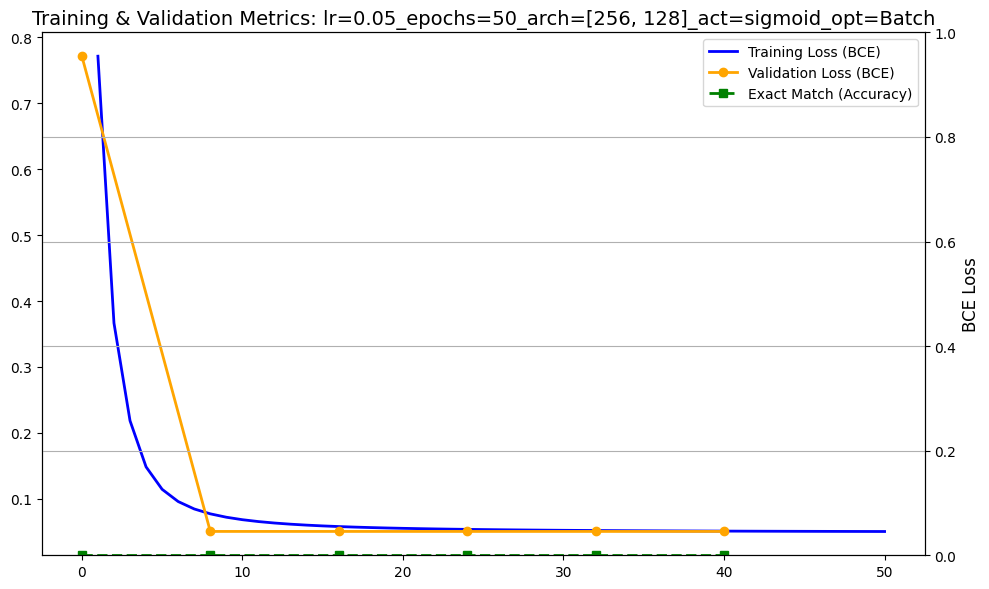


Training with lr=0.05_epochs=50_arch=[256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/50, Loss: 0.0495
Epoch 20/50, Loss: 0.0493
Epoch 30/50, Loss: 0.0492
Epoch 40/50, Loss: 0.0486
Epoch 50/50, Loss: 0.0435
Validation metrics: Hamming Loss=0.0112, Exact Match=0.3243, BCE Loss=0.0443
Test metrics: Hamming Loss=0.0107, Exact Match=0.3488, BCE Loss=0.0441
Training time: 14.42 seconds


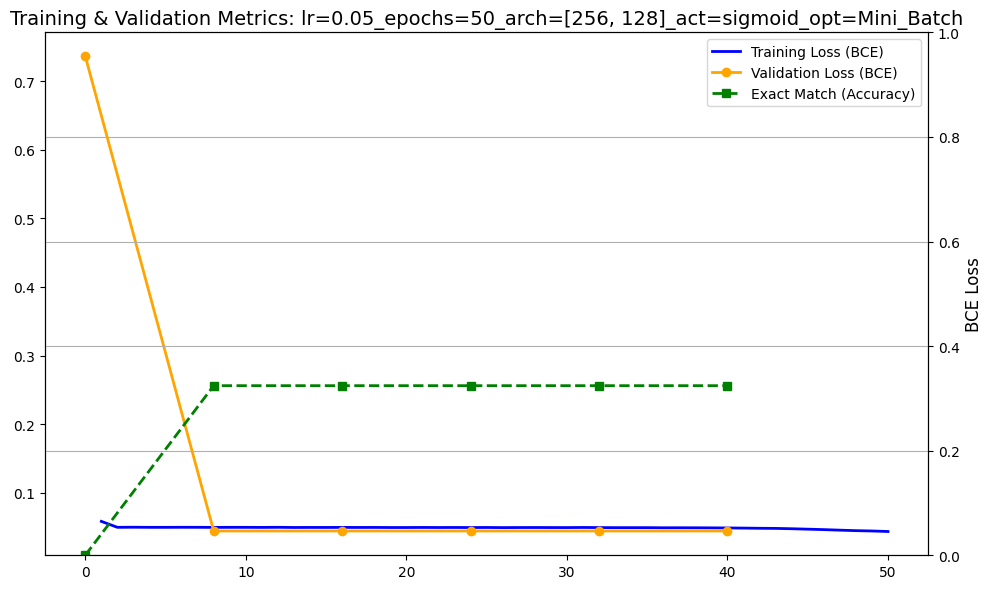


Training with lr=0.05_epochs=50_arch=[256, 128]_act=sigmoid_opt=SGD
Epoch 10/50, Loss: 0.0297
Epoch 20/50, Loss: 0.0197
Epoch 30/50, Loss: 0.0146
Epoch 40/50, Loss: 0.0113
Epoch 50/50, Loss: 0.0087
Validation metrics: Hamming Loss=0.0042, Exact Match=0.7587, BCE Loss=0.0156
Test metrics: Hamming Loss=0.0052, Exact Match=0.7254, BCE Loss=0.0194
Training time: 427.90 seconds


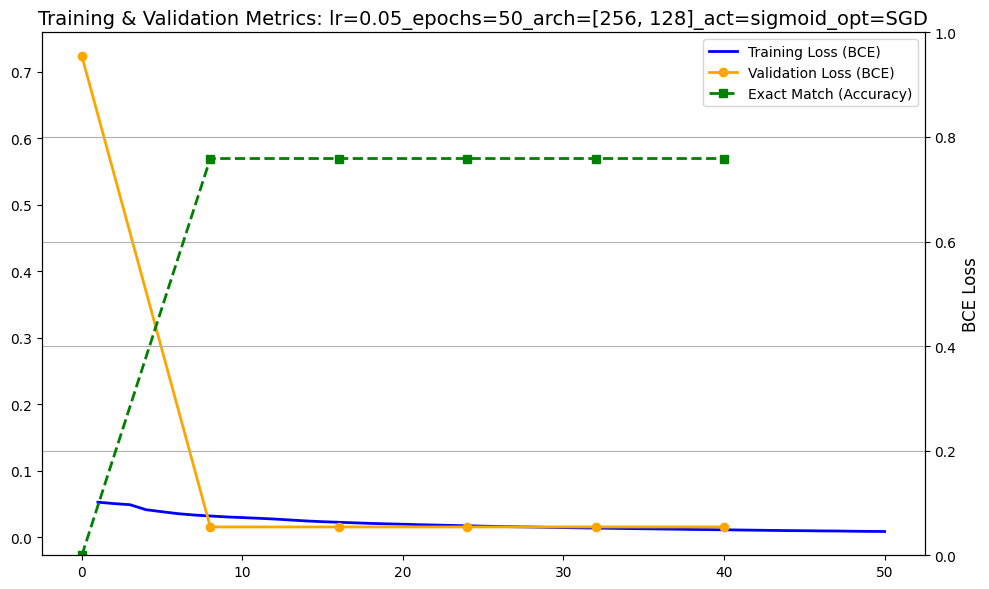


Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=relu_opt=Batch
Epoch 10/50, Loss: 0.0541
Epoch 20/50, Loss: 0.0527
Epoch 30/50, Loss: 0.0544
Epoch 40/50, Loss: 0.0515
Epoch 50/50, Loss: 0.0521
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0555
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0559
Training time: 2.05 seconds


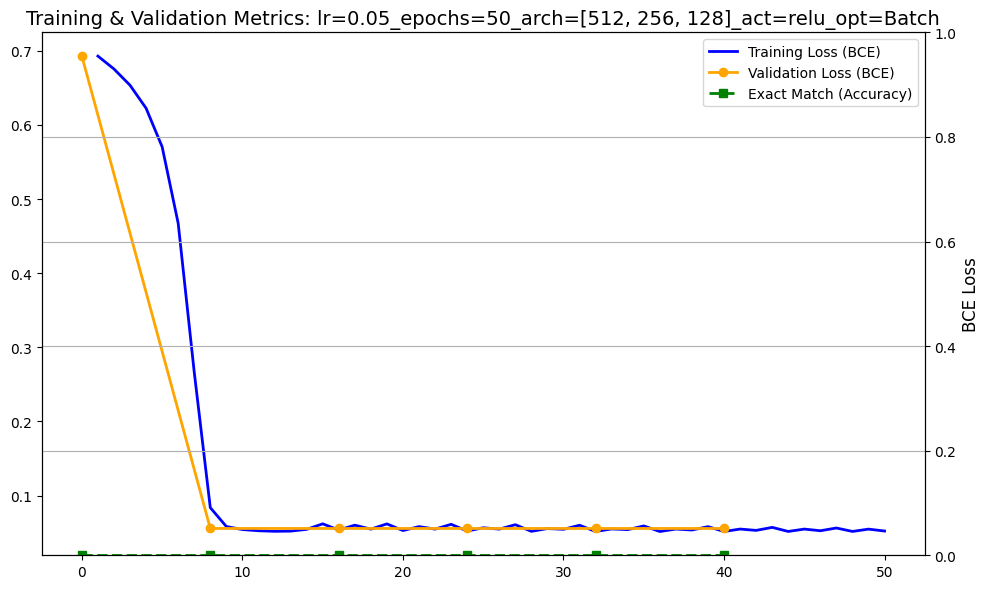


Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=relu_opt=Mini_Batch
Epoch 10/50, Loss: 0.0231
Epoch 20/50, Loss: 0.0146
Epoch 30/50, Loss: 0.0100
Epoch 40/50, Loss: 0.0068
Epoch 50/50, Loss: 0.0049
Validation metrics: Hamming Loss=0.0048, Exact Match=0.7033, BCE Loss=0.0210
Test metrics: Hamming Loss=0.0055, Exact Match=0.6814, BCE Loss=0.0239
Training time: 16.35 seconds


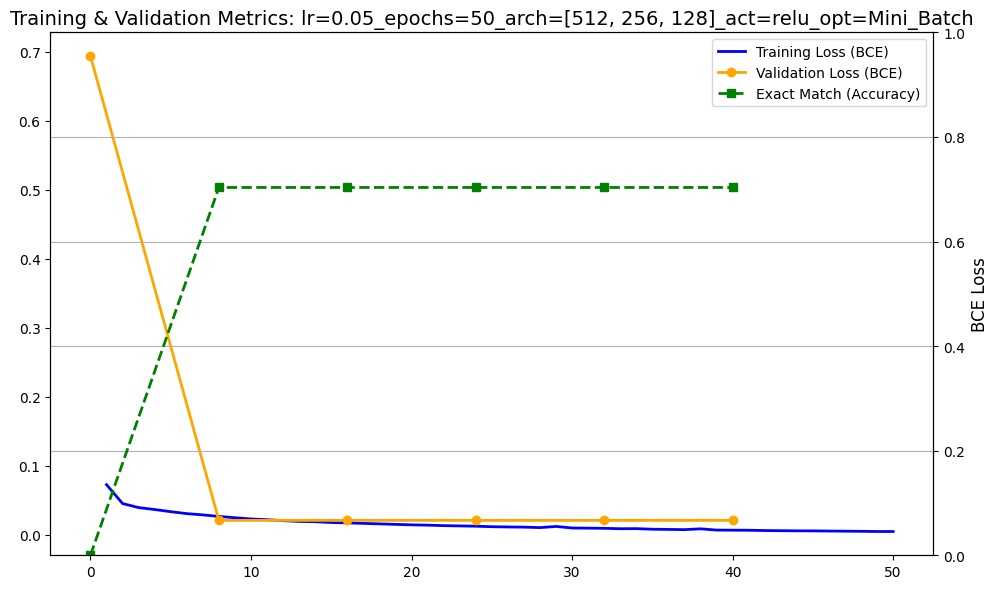


Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=relu_opt=SGD
Epoch 10/50, Loss: 0.0124
Epoch 20/50, Loss: 0.0097
Epoch 30/50, Loss: 0.0090
Epoch 40/50, Loss: 0.0082
Epoch 50/50, Loss: 0.0070
Validation metrics: Hamming Loss=0.0033, Exact Match=0.8385, BCE Loss=0.0163
Test metrics: Hamming Loss=0.0040, Exact Match=0.8019, BCE Loss=0.0182
Training time: 483.21 seconds


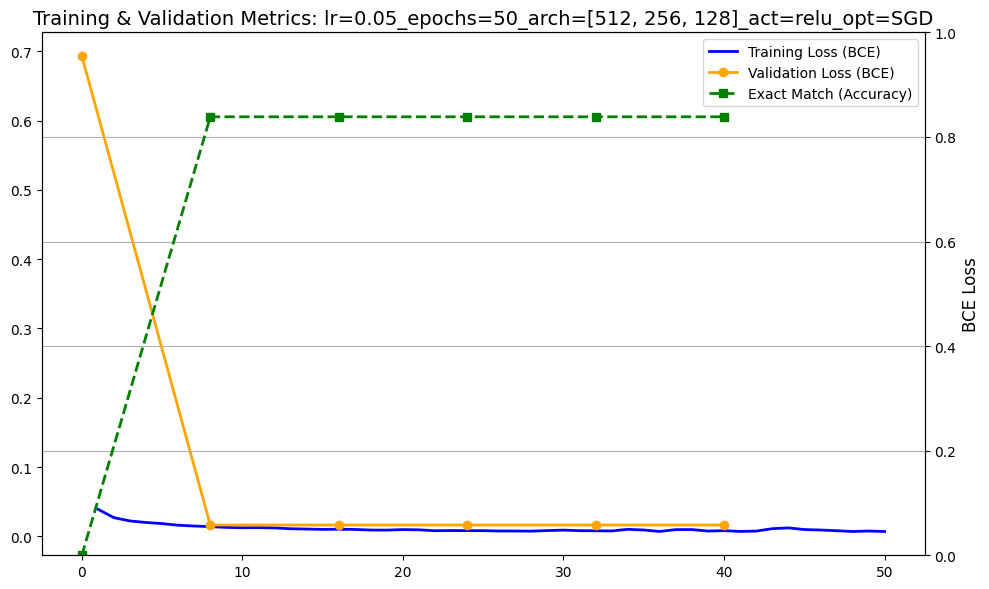


Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=tanh_opt=Batch
Epoch 10/50, Loss: 0.0733
Epoch 20/50, Loss: 0.0547
Epoch 30/50, Loss: 0.0517
Epoch 40/50, Loss: 0.0506
Epoch 50/50, Loss: 0.0501
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0502
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0506
Training time: 1.94 seconds



Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/50, Loss: 0.0301
Epoch 20/50, Loss: 0.0196
Epoch 30/50, Loss: 0.0141
Epoch 40/50, Loss: 0.0106
Epoch 50/50, Loss: 0.0083
Validation metrics: Hamming Loss=0.0041, Exact Match=0.7819, BCE Loss=0.0139
Test metrics: Hamming Loss=0.0049, Exact Match=0.7526, BCE Loss=0.0176
Training time: 15.45 seconds


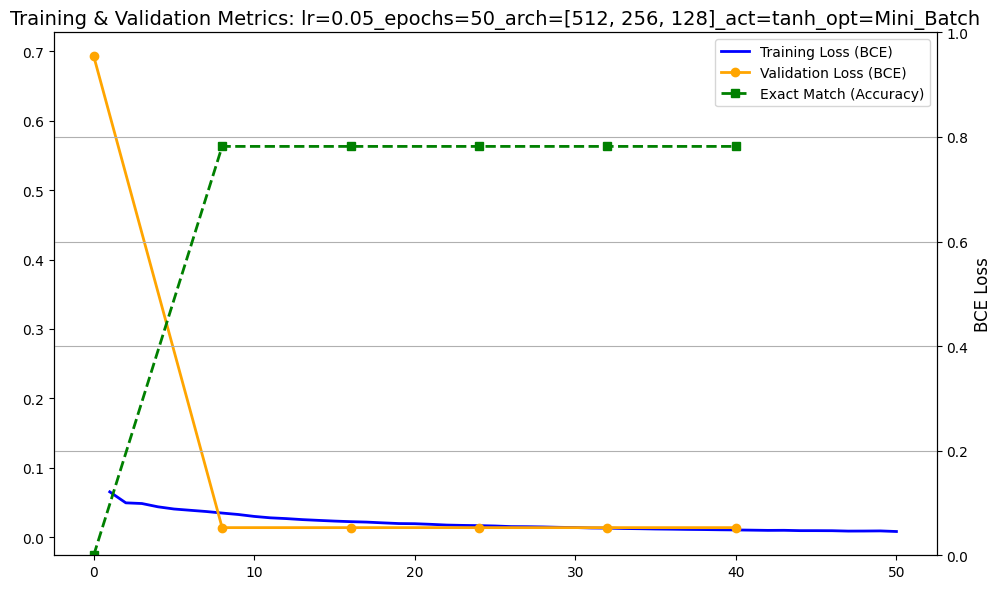


Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=tanh_opt=SGD
Epoch 10/50, Loss: 0.0568
Epoch 20/50, Loss: 0.0708
Epoch 30/50, Loss: 0.0587
Epoch 40/50, Loss: 0.0475
Epoch 50/50, Loss: 0.0430
Validation metrics: Hamming Loss=0.0091, Exact Match=0.5553, BCE Loss=0.0404
Test metrics: Hamming Loss=0.0087, Exact Match=0.5896, BCE Loss=0.0405
Training time: 449.80 seconds



Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=sigmoid_opt=Batch
Epoch 10/50, Loss: 0.0659
Epoch 20/50, Loss: 0.0544
Epoch 30/50, Loss: 0.0518
Epoch 40/50, Loss: 0.0507
Epoch 50/50, Loss: 0.0502
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0503
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0507
Training time: 2.02 seconds



Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/50, Loss: 0.0495
Epoch 20/50, Loss: 0.0494
Epoch 30/50, Loss: 0.0493
Epoch 40/50, Loss: 0.0492
Epoch 50/50, Loss: 0.0493
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0493
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0503
Training time: 18.14 seconds


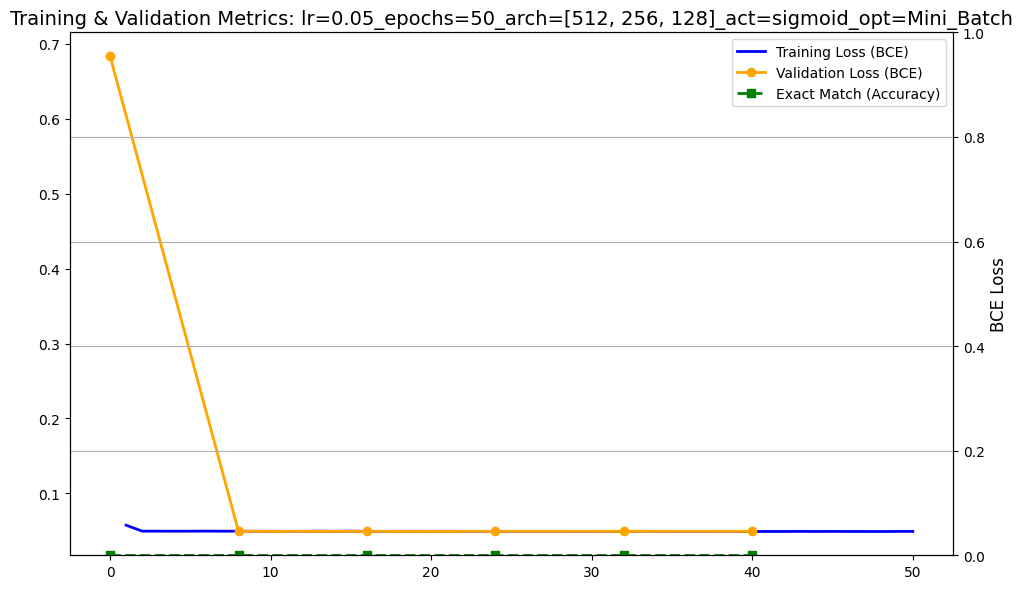


Training with lr=0.05_epochs=50_arch=[512, 256, 128]_act=sigmoid_opt=SGD
Epoch 10/50, Loss: 0.0332
Epoch 20/50, Loss: 0.0263
Epoch 30/50, Loss: 0.0243
Epoch 40/50, Loss: 0.0232
Epoch 50/50, Loss: 0.0222
Validation metrics: Hamming Loss=0.0082, Exact Match=0.5283, BCE Loss=0.0296
Test metrics: Hamming Loss=0.0084, Exact Match=0.5402, BCE Loss=0.0328
Training time: 542.12 seconds


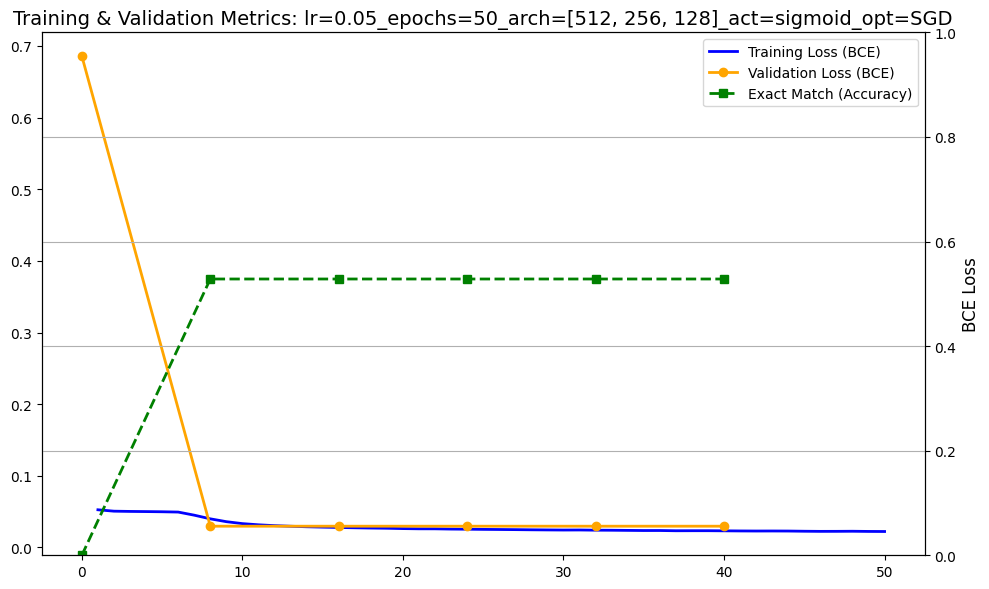


Training with lr=0.05_epochs=100_arch=[256, 128]_act=relu_opt=Batch
Epoch 10/100, Loss: 0.1432
Epoch 20/100, Loss: 0.0512
Epoch 30/100, Loss: 0.0495
Epoch 40/100, Loss: 0.0491
Epoch 50/100, Loss: 0.0488
Epoch 60/100, Loss: 0.0486
Epoch 70/100, Loss: 0.0485
Epoch 80/100, Loss: 0.0484
Epoch 90/100, Loss: 0.0489
Epoch 100/100, Loss: 0.0496
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0503
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0509
Training time: 2.31 seconds



Training with lr=0.05_epochs=100_arch=[256, 128]_act=relu_opt=Mini_Batch
Epoch 10/100, Loss: 0.0279
Epoch 20/100, Loss: 0.0196
Epoch 30/100, Loss: 0.0147
Epoch 40/100, Loss: 0.0113
Epoch 50/100, Loss: 0.0090
Epoch 60/100, Loss: 0.0073
Epoch 70/100, Loss: 0.0060
Epoch 80/100, Loss: 0.0050
Epoch 90/100, Loss: 0.0043
Epoch 100/100, Loss: 0.0036
Validation metrics: Hamming Loss=0.0033, Exact Match=0.8108, BCE Loss=0.0127
Test metrics: Hamming Loss=0.0044, Exact Match=0.7681, BCE Loss=0.0163
Training time: 26.39 seconds


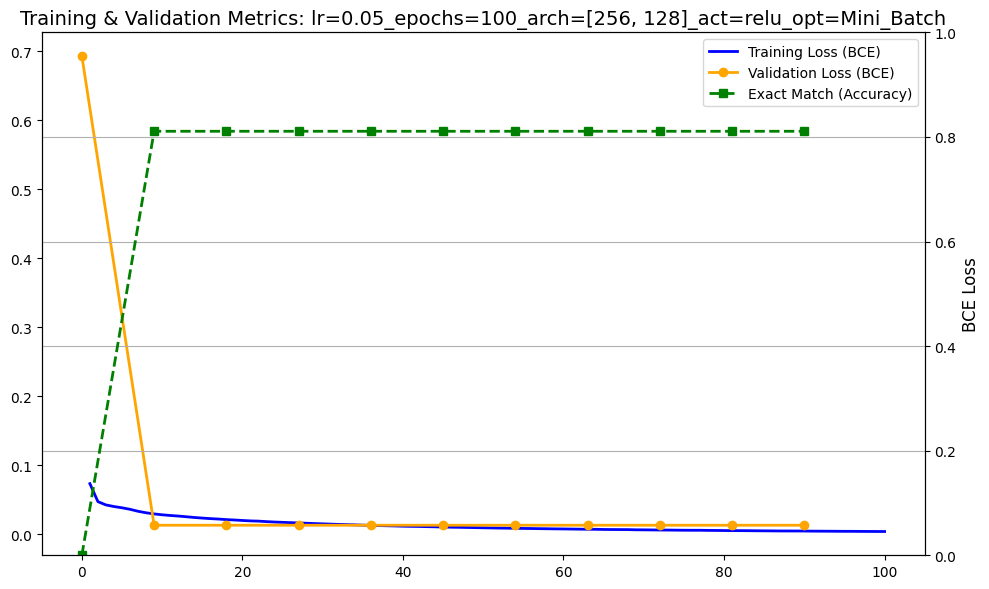


Training with lr=0.05_epochs=100_arch=[256, 128]_act=relu_opt=SGD
Epoch 10/100, Loss: 0.0064
Epoch 20/100, Loss: 0.0031
Epoch 30/100, Loss: 0.0014
Epoch 40/100, Loss: 0.0013
Epoch 50/100, Loss: 0.0007
Epoch 60/100, Loss: 0.0005
Epoch 70/100, Loss: 0.0005
Epoch 80/100, Loss: 0.0004
Epoch 90/100, Loss: 0.0004
Epoch 100/100, Loss: 0.0004
Validation metrics: Hamming Loss=0.0027, Exact Match=0.8559, BCE Loss=0.0197
Test metrics: Hamming Loss=0.0037, Exact Match=0.8148, BCE Loss=0.0249
Training time: 788.35 seconds


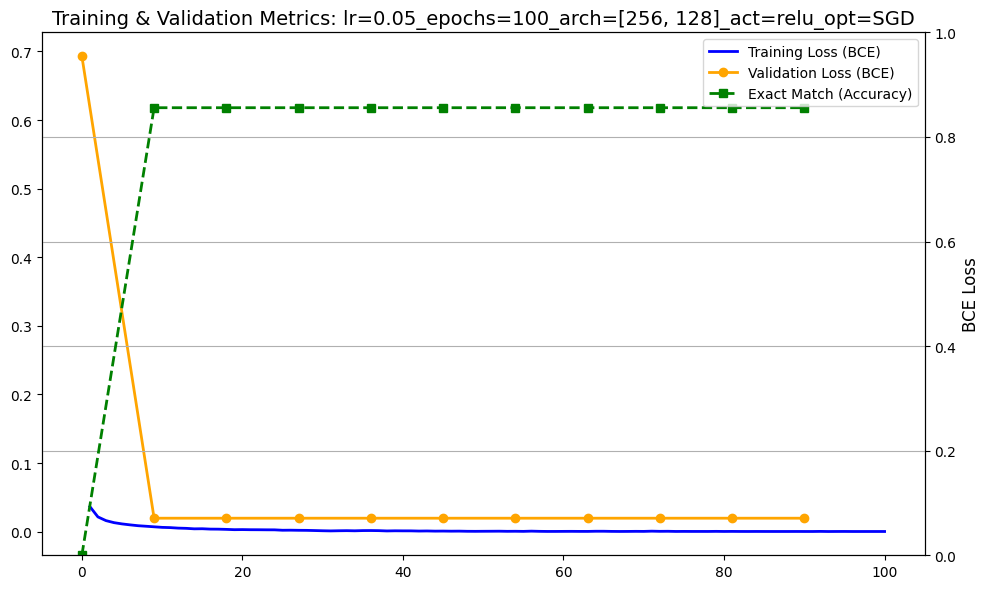


Training with lr=0.05_epochs=100_arch=[256, 128]_act=tanh_opt=Batch
Epoch 10/100, Loss: 0.1212
Epoch 20/100, Loss: 0.0595
Epoch 30/100, Loss: 0.0535
Epoch 40/100, Loss: 0.0515
Epoch 50/100, Loss: 0.0506
Epoch 60/100, Loss: 0.0501
Epoch 70/100, Loss: 0.0498
Epoch 80/100, Loss: 0.0496
Epoch 90/100, Loss: 0.0495
Epoch 100/100, Loss: 0.0494
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0495
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0500
Training time: 2.45 seconds


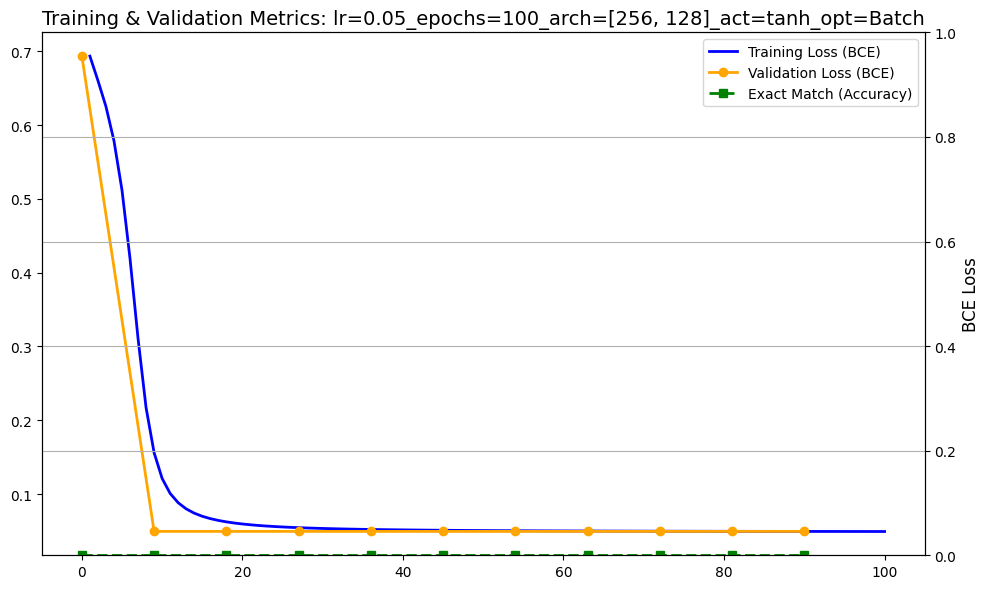


Training with lr=0.05_epochs=100_arch=[256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/100, Loss: 0.0328
Epoch 20/100, Loss: 0.0236
Epoch 30/100, Loss: 0.0183
Epoch 40/100, Loss: 0.0146
Epoch 50/100, Loss: 0.0117
Epoch 60/100, Loss: 0.0096
Epoch 70/100, Loss: 0.0081
Epoch 80/100, Loss: 0.0071
Epoch 90/100, Loss: 0.0060
Epoch 100/100, Loss: 0.0051
Validation metrics: Hamming Loss=0.0036, Exact Match=0.7973, BCE Loss=0.0131
Test metrics: Hamming Loss=0.0045, Exact Match=0.7655, BCE Loss=0.0166
Training time: 23.65 seconds


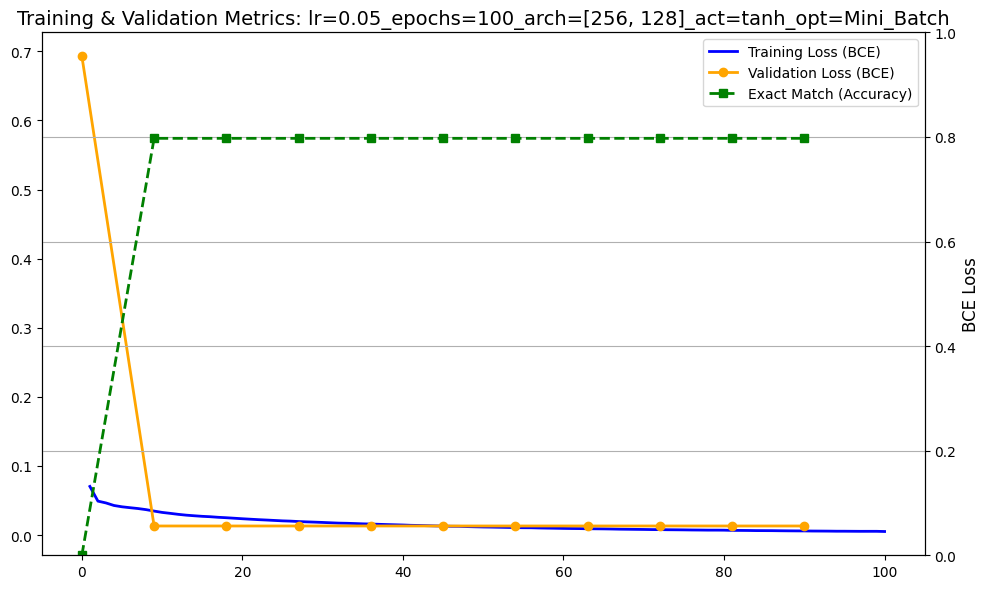


Training with lr=0.05_epochs=100_arch=[256, 128]_act=tanh_opt=SGD
Epoch 10/100, Loss: 0.0051
Epoch 20/100, Loss: 0.0018
Epoch 30/100, Loss: 0.0011
Epoch 40/100, Loss: 0.0008
Epoch 50/100, Loss: 0.0007
Epoch 60/100, Loss: 0.0007
Epoch 70/100, Loss: 0.0006
Epoch 80/100, Loss: 0.0005
Epoch 90/100, Loss: 0.0005
Epoch 100/100, Loss: 0.0006
Validation metrics: Hamming Loss=0.0030, Exact Match=0.8366, BCE Loss=0.0183
Test metrics: Hamming Loss=0.0036, Exact Match=0.8165, BCE Loss=0.0231
Training time: 702.20 seconds



Training with lr=0.05_epochs=100_arch=[256, 128]_act=sigmoid_opt=Batch
Epoch 10/100, Loss: 0.0682
Epoch 20/100, Loss: 0.0552
Epoch 30/100, Loss: 0.0522
Epoch 40/100, Loss: 0.0510
Epoch 50/100, Loss: 0.0504
Epoch 60/100, Loss: 0.0500
Epoch 70/100, Loss: 0.0498
Epoch 80/100, Loss: 0.0496
Epoch 90/100, Loss: 0.0495
Epoch 100/100, Loss: 0.0494
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0496
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0502
Training time: 2.38 seconds


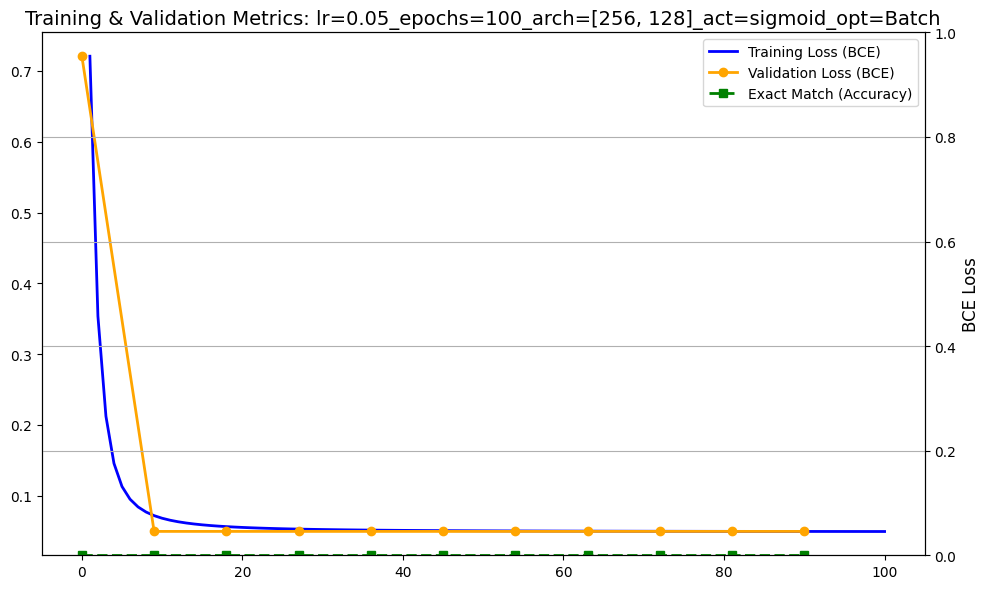


Training with lr=0.05_epochs=100_arch=[256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/100, Loss: 0.0495
Epoch 20/100, Loss: 0.0493
Epoch 30/100, Loss: 0.0493
Epoch 40/100, Loss: 0.0488
Epoch 50/100, Loss: 0.0442
Epoch 60/100, Loss: 0.0408
Epoch 70/100, Loss: 0.0394
Epoch 80/100, Loss: 0.0386
Epoch 90/100, Loss: 0.0375
Epoch 100/100, Loss: 0.0366
Validation metrics: Hamming Loss=0.0109, Exact Match=0.3514, BCE Loss=0.0375
Test metrics: Hamming Loss=0.0109, Exact Match=0.3534, BCE Loss=0.0380
Training time: 28.53 seconds



Training with lr=0.05_epochs=100_arch=[256, 128]_act=sigmoid_opt=SGD
Epoch 10/100, Loss: 0.0299
Epoch 20/100, Loss: 0.0200
Epoch 30/100, Loss: 0.0156
Epoch 40/100, Loss: 0.0117
Epoch 50/100, Loss: 0.0088
Epoch 60/100, Loss: 0.0069
Epoch 70/100, Loss: 0.0054
Epoch 80/100, Loss: 0.0043
Epoch 90/100, Loss: 0.0036
Epoch 100/100, Loss: 0.0029
Validation metrics: Hamming Loss=0.0039, Exact Match=0.7986, BCE Loss=0.0155
Test metrics: Hamming Loss=0.0050, Exact Match=0.7552, BCE Loss=0.0203
Training time: 857.04 seconds


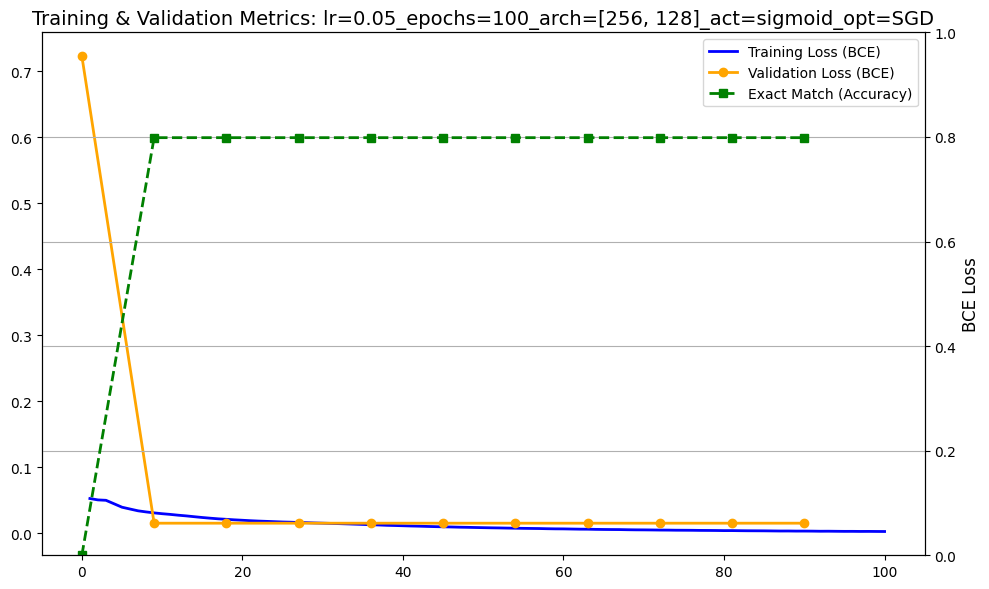


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=relu_opt=Batch
Epoch 10/100, Loss: 0.0543
Epoch 20/100, Loss: 0.0536
Epoch 30/100, Loss: 0.0609
Epoch 40/100, Loss: 0.0548
Epoch 50/100, Loss: 0.0554
Epoch 60/100, Loss: 0.0541
Epoch 70/100, Loss: 0.0534
Epoch 80/100, Loss: 0.0528
Epoch 90/100, Loss: 0.0523
Epoch 100/100, Loss: 0.0518
Validation metrics: Hamming Loss=0.0166, Exact Match=0.3668, BCE Loss=0.0505
Test metrics: Hamming Loss=0.0169, Exact Match=0.3587, BCE Loss=0.0513
Training time: 4.01 seconds


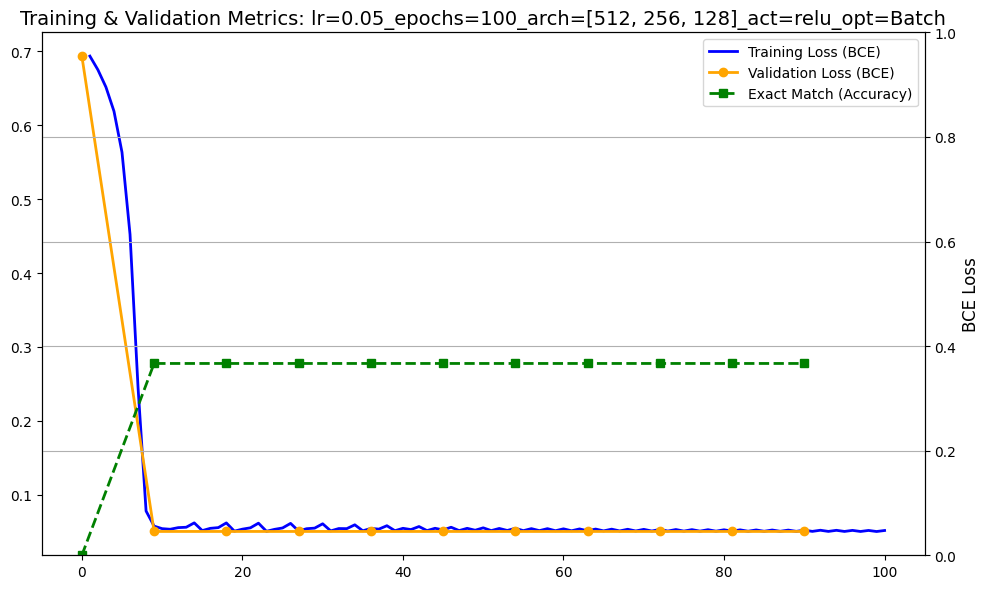


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=relu_opt=Mini_Batch
Epoch 10/100, Loss: 0.0223
Epoch 20/100, Loss: 0.0132
Epoch 30/100, Loss: 0.0089
Epoch 40/100, Loss: 0.0062
Epoch 50/100, Loss: 0.0052
Epoch 60/100, Loss: 0.0045
Epoch 70/100, Loss: 0.0027
Epoch 80/100, Loss: 0.0021
Epoch 90/100, Loss: 0.0019
Epoch 100/100, Loss: 0.0015
Validation metrics: Hamming Loss=0.0031, Exact Match=0.8340, BCE Loss=0.0148
Test metrics: Hamming Loss=0.0039, Exact Match=0.7943, BCE Loss=0.0201
Training time: 32.95 seconds


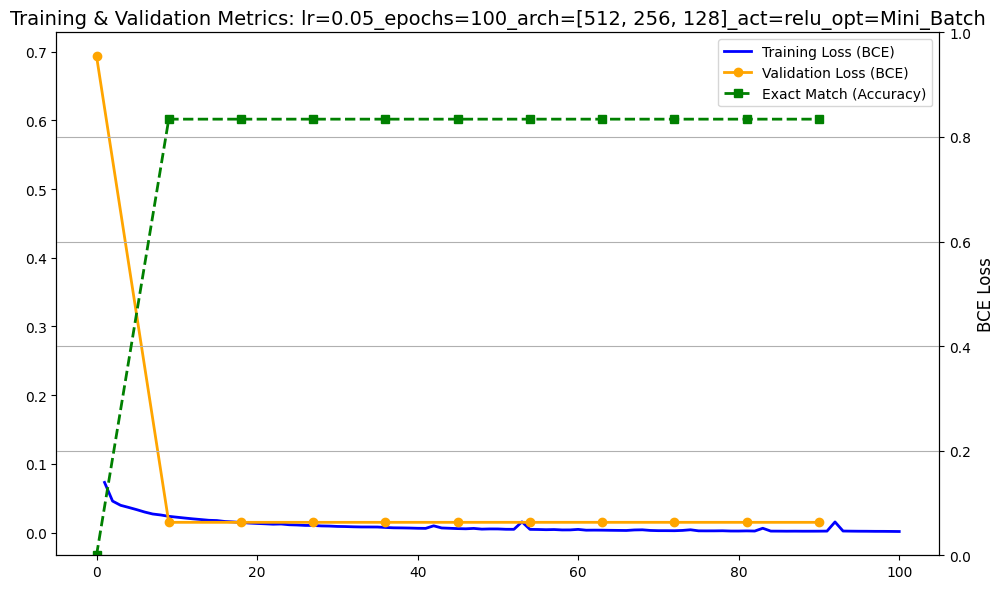


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=relu_opt=SGD
Epoch 10/100, Loss: 0.0130
Epoch 20/100, Loss: 0.0100
Epoch 30/100, Loss: 0.0090
Epoch 40/100, Loss: 0.0089
Epoch 50/100, Loss: 0.0127
Epoch 60/100, Loss: 0.0077
Epoch 70/100, Loss: 0.0092
Epoch 80/100, Loss: 0.0100
Epoch 90/100, Loss: 0.0112
Epoch 100/100, Loss: 0.0098
Validation metrics: Hamming Loss=0.0042, Exact Match=0.7883, BCE Loss=0.0176
Test metrics: Hamming Loss=0.0049, Exact Match=0.7642, BCE Loss=0.0203
Training time: 965.26 seconds


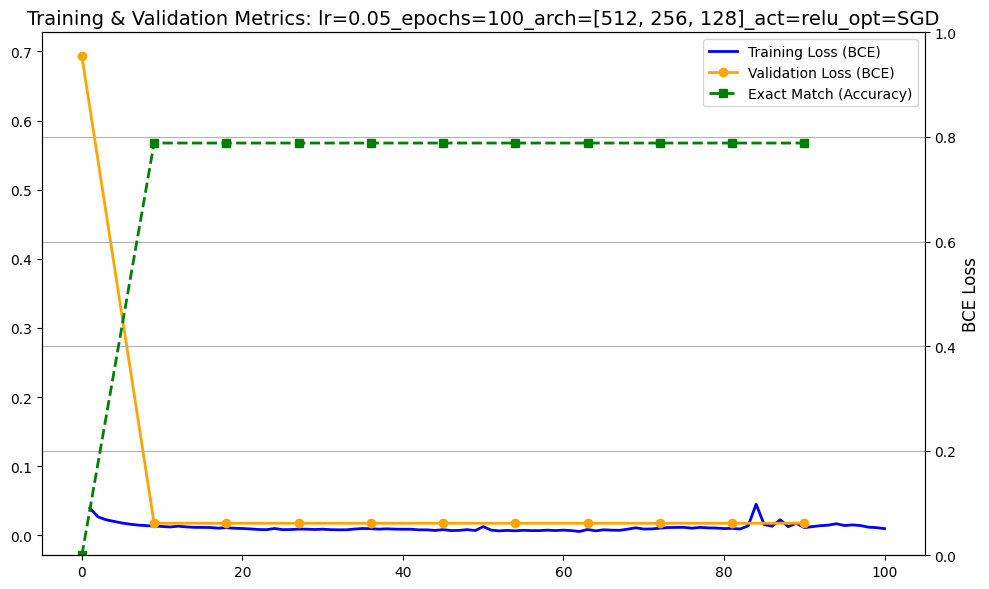


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=tanh_opt=Batch
Epoch 10/100, Loss: 0.0753
Epoch 20/100, Loss: 0.0548
Epoch 30/100, Loss: 0.0518
Epoch 40/100, Loss: 0.0506
Epoch 50/100, Loss: 0.0501
Epoch 60/100, Loss: 0.0498
Epoch 70/100, Loss: 0.0496
Epoch 80/100, Loss: 0.0494
Epoch 90/100, Loss: 0.0493
Epoch 100/100, Loss: 0.0493
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0494
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0500
Training time: 3.90 seconds


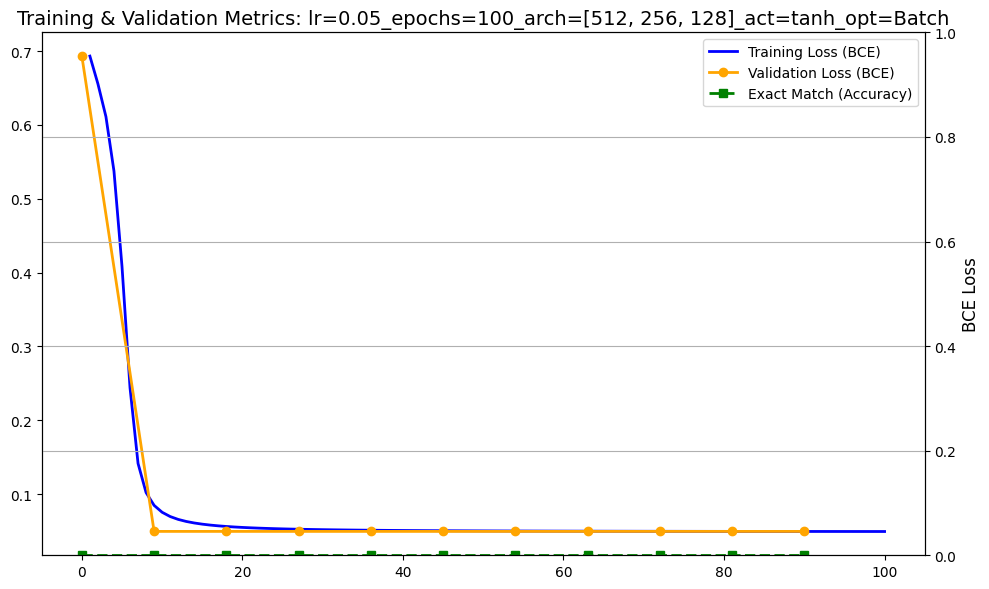


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=tanh_opt=Mini_Batch
Epoch 10/100, Loss: 0.0304
Epoch 20/100, Loss: 0.0196
Epoch 30/100, Loss: 0.0139
Epoch 40/100, Loss: 0.0105
Epoch 50/100, Loss: 0.0085
Epoch 60/100, Loss: 0.0068
Epoch 70/100, Loss: 0.0055
Epoch 80/100, Loss: 0.0046
Epoch 90/100, Loss: 0.0042
Epoch 100/100, Loss: 0.0033
Validation metrics: Hamming Loss=0.0037, Exact Match=0.7999, BCE Loss=0.0144
Test metrics: Hamming Loss=0.0046, Exact Match=0.7698, BCE Loss=0.0186
Training time: 30.94 seconds


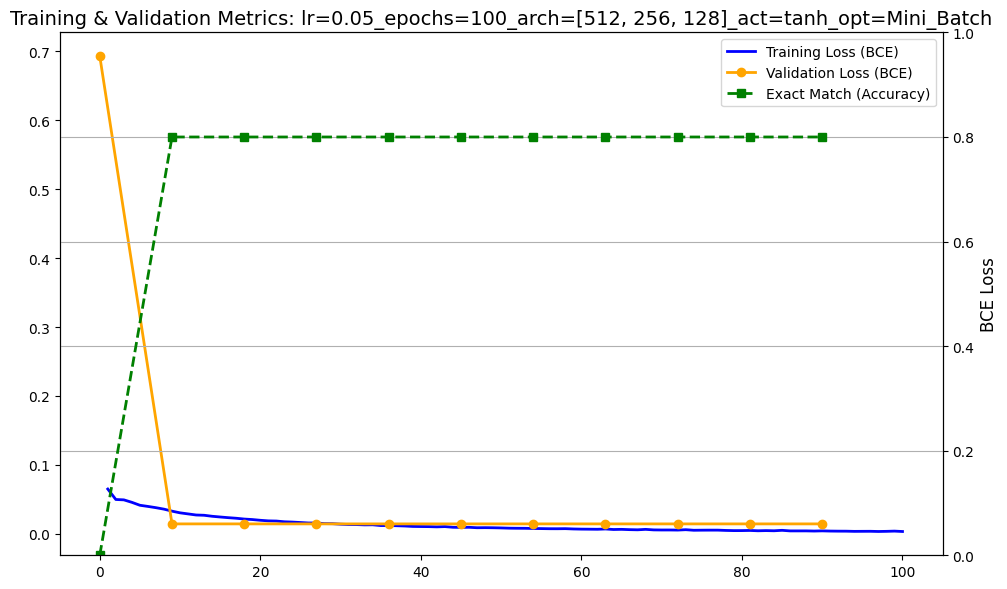


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=tanh_opt=SGD
Epoch 10/100, Loss: 0.0707
Epoch 20/100, Loss: 0.0814
Epoch 30/100, Loss: 0.0807
Epoch 40/100, Loss: 0.0814
Epoch 50/100, Loss: 0.0811
Epoch 60/100, Loss: 0.0814
Epoch 70/100, Loss: 0.0813
Epoch 80/100, Loss: 0.0814
Epoch 90/100, Loss: 0.0814
Epoch 100/100, Loss: 0.0813
Validation metrics: Hamming Loss=0.0245, Exact Match=0.0122, BCE Loss=0.0908
Test metrics: Hamming Loss=0.0246, Exact Match=0.0093, BCE Loss=0.0921
Training time: 897.15 seconds



Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=sigmoid_opt=Batch
Epoch 10/100, Loss: 0.0660
Epoch 20/100, Loss: 0.0544
Epoch 30/100, Loss: 0.0518
Epoch 40/100, Loss: 0.0508
Epoch 50/100, Loss: 0.0502
Epoch 60/100, Loss: 0.0499
Epoch 70/100, Loss: 0.0497
Epoch 80/100, Loss: 0.0495
Epoch 90/100, Loss: 0.0494
Epoch 100/100, Loss: 0.0494
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0495
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0501
Training time: 4.03 seconds


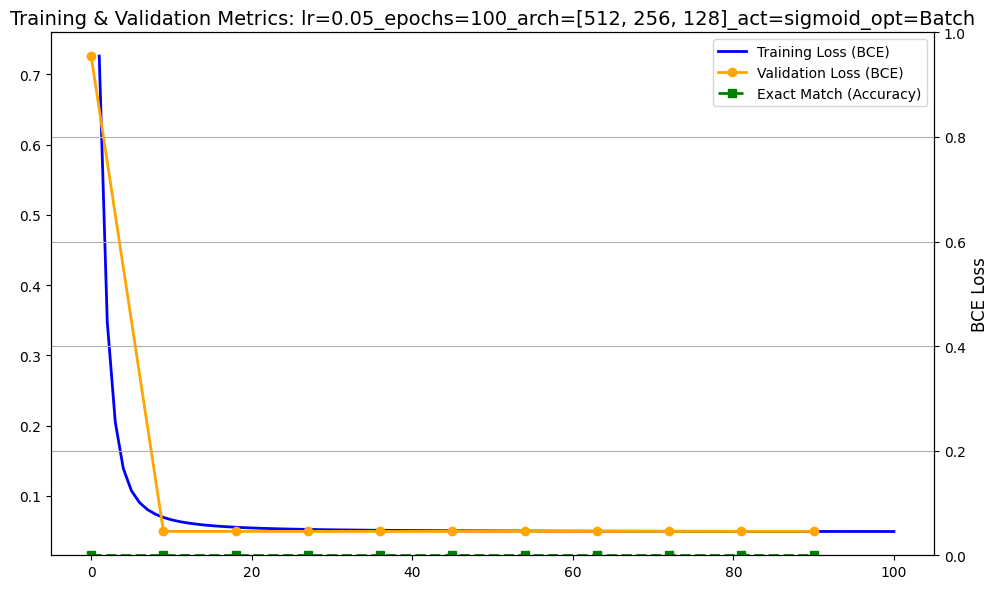


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=sigmoid_opt=Mini_Batch
Epoch 10/100, Loss: 0.0494
Epoch 20/100, Loss: 0.0494
Epoch 30/100, Loss: 0.0493
Epoch 40/100, Loss: 0.0492
Epoch 50/100, Loss: 0.0493
Epoch 60/100, Loss: 0.0492
Epoch 70/100, Loss: 0.0492
Epoch 80/100, Loss: 0.0491
Epoch 90/100, Loss: 0.0491
Epoch 100/100, Loss: 0.0491
Validation metrics: Hamming Loss=0.0137, Exact Match=0.0000, BCE Loss=0.0493
Test metrics: Hamming Loss=0.0138, Exact Match=0.0000, BCE Loss=0.0501
Training time: 36.21 seconds


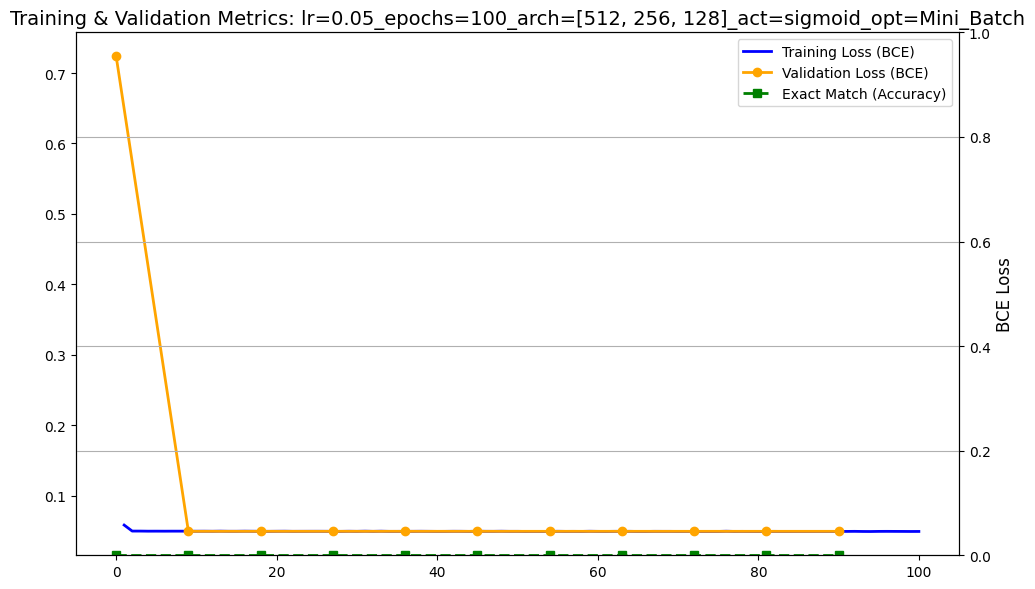


Training with lr=0.05_epochs=100_arch=[512, 256, 128]_act=sigmoid_opt=SGD
Epoch 10/100, Loss: 0.0331
Epoch 20/100, Loss: 0.0264
Epoch 30/100, Loss: 0.0244
Epoch 40/100, Loss: 0.0232
Epoch 50/100, Loss: 0.0222
Epoch 60/100, Loss: 0.0210
Epoch 70/100, Loss: 0.0187
Epoch 80/100, Loss: 0.0154
Epoch 90/100, Loss: 0.0137
Epoch 100/100, Loss: 0.0128
Validation metrics: Hamming Loss=0.0070, Exact Match=0.6532, BCE Loss=0.0259
Test metrics: Hamming Loss=0.0079, Exact Match=0.6346, BCE Loss=0.0305
Training time: 1082.76 seconds


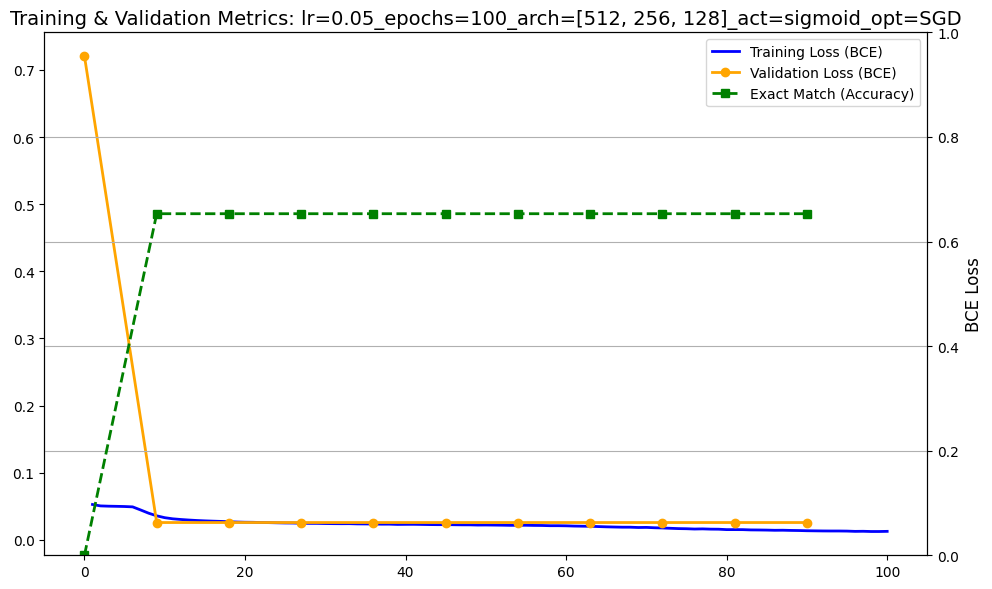


======= MODEL CONFIGURATIONS RANKED BY HAMMING LOSS (BEST TO WORST) =======
Rank Learning Rate  Architecture        ActivationOptimizer      Hamming LossExact Match BCE Loss    
1    0.05           [256, 128]          tanh      SGD            0.00361      0.81650      0.02312
2    0.05           [256, 128]          tanh      SGD            0.00365      0.81418      0.02206
3    0.05           [256, 128]          relu      SGD            0.00365      0.81484      0.02495
4    0.05           [256, 128]          relu      SGD            0.00373      0.80689      0.02398
5    0.01           [256, 128]          relu      SGD            0.00387      0.79132      0.01940
6    0.01           [512, 256, 128]     relu      SGD            0.00388      0.80788      0.02224
7    0.05           [512, 256, 128]     relu      Mini_Batch     0.00393      0.79430      0.02007
8    0.05           [512, 256, 128]     relu      SGD            0.00396      0.80192      0.01823
9    0.01           [256, 128

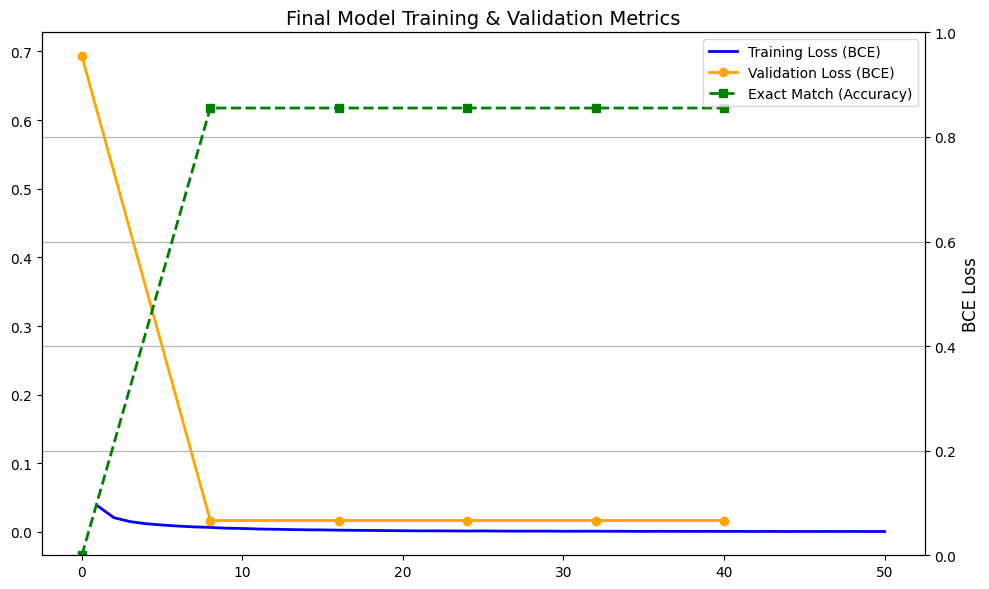

Final Test Metrics:
  Hamming Loss: 0.0035
  Exact Match: 0.8145
  BCE Loss: 0.0223


In [11]:


train_file = "/kaggle/input/smai-news/train.csv"
test_file = "/kaggle/input/smai-news/test.csv"

# Initialize data processor
data_processor = ArticleDataProcessor(max_features=5000)

# Process data
X_train, Y_train, X_val, Y_val, X_test, Y_test = data_processor.prepare_data(
    train_file, test_file, val_split=0.2
)

# Print data shapes
print(f"Data shapes:")
print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

# Initialize classifier
classifier = NewsClassifier(X_train.shape[1], Y_train.shape[1])

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05],
    'epochs': [50, 100],
    'hidden_sizes': [[256, 128], [512, 256, 128]],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['Batch', 'Mini_Batch', 'SGD']
}

# Run hyperparameter search
results, best_config, act_opt_performance = classifier.run_hyperparameter_search(
    X_train, Y_train, X_val, Y_val, X_test, Y_test, param_grid
)

# Train final model with best configuration
final_model, final_metrics = classifier.train_final_model(
    X_train, Y_train, X_val, Y_val, X_test, Y_test, best_config
)
